In [1]:
import os

import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
import urllib.request
import seaborn as sns
import plotly.express as px
import folium
from random import sample
import geopandas as gpd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

/Users/chloeroudaut/anaconda3/envs/myenv/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#importation des données:
customers = pd.read_csv('olist_customers_dataset.csv')
geolocalisation = pd.read_csv('olist_geolocation_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
order_payments = pd.read_csv('olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
translation = pd.read_csv('product_category_name_translation.csv')

### Fichier 

In [3]:
orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [4]:
order_items.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [5]:
order_payments.columns

Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')

In [6]:
order_reviews.columns

Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

Merge par 'order_id'

In [7]:
customers.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')

Merge par 'customer_id'

In [8]:
products.columns

Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')

Merge par 'product_id'

In [9]:
translation.columns

Index(['product_category_name', 'product_category_name_english'], dtype='object')

Merge par 'product_category_name'

In [10]:
sellers.columns

Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state'], dtype='object')

Merge par 'seller_id'

In [11]:
geolocalisation.columns

Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state'],
      dtype='object')

Merge par 'geolocation_zip_code_prefix' et customer_zip_code_prefix

Pas de lien avec des Data pour Sellers et Geolocalisation

### Merge

In [12]:
data = pd.merge(orders, order_items, on="order_id")

In [13]:
data = pd.merge(data, order_payments, on="order_id")

In [14]:
data = pd.merge(data, order_reviews, on="order_id")

In [15]:
data = pd.merge(data, customers, on="customer_id")

In [16]:
data = pd.merge(data, products, on="product_id")

In [17]:
data = pd.merge(data, translation , on="product_category_name")

In [18]:
data = pd.merge(data, sellers , on="seller_id")

In [19]:
geo_aggregated = geolocalisation.groupby('geolocation_zip_code_prefix').agg({
    'geolocation_lat': 'mean',
    'geolocation_lng': 'mean',
}).reset_index()


Moyennes des lat et lng car plusieurs données pour un seul code postal, cela ajouter des lignes à la DF merge final

In [20]:
data = pd.merge(data, geo_aggregated , 
                       left_on='customer_zip_code_prefix', 
                       right_on='geolocation_zip_code_prefix', 
                       how='left')

In [21]:
data.shape

(115609, 43)

In [22]:
data.drop_duplicates("customer_id", inplace=True)
data.reset_index(drop = True, inplace = True)

In [23]:
data.shape

(96516, 43)

Suppression des valeurs dupliquées par rapport aux commandes, cette valeur doit être unique. L'index est réinitialisé.

### Exploration

In [24]:
data.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_category_name_english', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'geolocation_zip_code_prefix',
       'geolocation_la

In [25]:
data

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,housewares,9350,maua,SP,3149.0,-23.576983,-46.587161
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,595fac2a385ac33a80bd5114aec74eb8,...,19.0,13.0,19.0,perfumery,31570,belo horizonte,SP,47813.0,-12.177924,-44.660711
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1,aa4383b373c6aca5d8797843e5594415,...,24.0,19.0,21.0,auto,14840,guariba,SP,75265.0,-16.745150,-48.514783
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,1,d0b61bfb1de832b15ba9d266ca96e5b0,...,30.0,10.0,20.0,pet_shop,31842,belo horizonte,MG,59296.0,-5.774190,-35.271143
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1,65266b2da20d04dbe00c5c2d3bb7859e,...,51.0,15.0,15.0,stationery,8752,mogi das cruzes,SP,9195.0,-23.676370,-46.514627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96511,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,1,ac35486adb7b02598c182c2ff2e05254,...,22.0,13.0,18.0,health_beauty,12913,braganca paulista,SP,12209.0,-23.178000,-45.883818
96512,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,1,f1d4ce8c6dd66c47bbaa8c6781c2a923,...,40.0,10.0,40.0,baby,17602,tupa,SP,11722.0,-24.001500,-46.449864
96513,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,1,b80910977a37536adeddd63663f916ad,...,32.0,90.0,22.0,home_appliances_2,8290,sao paulo,SP,45920.0,-17.898358,-39.373630
96514,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,1,d1c427060a0f73f6b889a5c7c61f2ac4,...,20.0,20.0,20.0,computers_accessories,37175,ilicinea,MG,28685.0,-22.562825,-42.694574


In [26]:
data.describe()

,order_item_id,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,customer_zip_code_prefix,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
count,96516.000000,96516.000000,96516.000000,96516.000000,96516.000000,96516.000000,96516.000000,96516.000000,96516.000000,96516.000000,96516.000000,96515.000000,96515.000000,96515.000000,96515.000000,96516.000000,96249.000000,96249.000000,96249.000000
mean,1.000300,125.849899,20.234453,1.022545,2.919858,157.924421,4.107412,35163.974543,48.846409,794.035403,2.250663,2106.245454,30.152743,16.508501,23.064891,24691.067668,35086.000249,-21.191556,-46.177976
std,0.019577,189.703511,15.936528,0.247935,2.711997,216.773702,1.329213,29810.746531,9.998403,654.646798,1.747789,3766.835729,16.156780,13.345260,11.749296,27754.514908,29797.875656,5.610097,4.057864
min,1.000000,0.850000,0.000000,1.000000,0.000000,0.010000,1.000000,1003.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1001.000000,1003.000000,-33.689948,-72.668881
25%,1.000000,41.900000,13.330000,1.000000,1.000000,60.065000,4.000000,11368.750000,42.000000,349.000000,1.000000,300.000000,18.000000,8.000000,15.000000,6429.000000,11325.000000,-23.589481,-48.106375
50%,1.000000,79.000000,16.390000,1.000000,2.000000,103.190000,5.000000,24422.000000,52.000000,607.000000,2.000000,700.000000,25.000000,13.000000,20.000000,13660.000000,24350.000000,-22.924970,-46.631239
75%,1.000000,139.900000,21.280000,1.000000,4.000000,175.392500,5.000000,59015.000000,57.000000,996.000000,3.000000,1813.000000,38.000000,20.000000,30.000000,29156.000000,58418.000000,-20.139441,-43.600508
max,4.000000,6735.000000,409.680000,27.000000,24.000000,13664.080000,5.000000,99980.000000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,99730.000000,99980.000000,42.184003,-8.723762


In [27]:
data.isna().mean()

order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.000135
order_delivered_carrier_date     0.009936
order_delivered_customer_date    0.021033
order_estimated_delivery_date    0.000000
order_item_id                    0.000000
product_id                       0.000000
seller_id                        0.000000
shipping_limit_date              0.000000
price                            0.000000
freight_value                    0.000000
payment_sequential               0.000000
payment_type                     0.000000
payment_installments             0.000000
payment_value                    0.000000
review_id                        0.000000
review_score                     0.000000
review_comment_title             0.881968
review_comment_message           0.589032
review_creation_date             0.000000
review_answer_timestamp          0

Je regarde les deux variables qui m'ont l'air similaire

In [28]:
selected_columns = ['customer_unique_id', 'customer_id']
data_selected = data[selected_columns]

print(data_selected)

                     customer_unique_id                       customer_id
0      7c396fd4830fd04220f754e42b4e5bff  9ef432eb6251297304e76186b10a928d
1      af07308b275d755c9edb36a90c618231  b0830fb4747a6c6d20dea0b8c802d7ef
2      3a653a41f6f9fc3d2a113cf8398680e8  41ce2a54c0b03bf3443c3d931a367089
3      7c142cf63193a1473d2e66489a9ae977  f88197465ea7920adcdbec7375364d82
4      72632f0f9dd73dfee390c9b22eb56dd6  8ab97904e6daea8866dbdbc4fb7aad2c
...                                 ...                               ...
96511  6359f309b166b0196dbf7ad2ac62bb5a  39bd1228ee8140590ac3aca26f2dfe00
96512  da62f9e57a76d978d02ab5362c509660  1fca14ff2861355f6e5f14306ff977a7
96513  737520a9aad80b3fbbdad19b66b37b30  1aa71eb042121263aafbe80c1b562c9c
96514  5097a5312c8b157bb7be58ae360ef43c  b331b74b18dc79bcdf6532d51e1637c1
96515  60350aa974b26ff12caad89e55993bd6  edb027a75a1449115f6b43211ae02a24

[96516 rows x 2 columns]


In [29]:
data[['customer_unique_id', 'customer_id']].nunique()

customer_unique_id    93396
customer_id           96516
dtype: int64

Elles ne sont pas similaires

In [30]:
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])
data['order_approved_at'] = pd.to_datetime(data['order_approved_at'])
data['order_delivered_carrier_date'] = pd.to_datetime(data['order_delivered_carrier_date'])
data['order_delivered_customer_date'] = pd.to_datetime(data['order_delivered_customer_date'])
data['order_estimated_delivery_date'] = pd.to_datetime(data['order_estimated_delivery_date'])

Traitement des valeurs manquantes

In [31]:
tx_remplissage = 1 - data.isna().sum()/len(data)
tx_remplissage = pd.DataFrame(tx_remplissage)
tx_remplissage = tx_remplissage.transpose()
tx_remplissage

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
0,1.0,1.0,1.0,1.0,0.999865,0.990064,0.978967,1.0,1.0,1.0,...,0.99999,0.99999,0.99999,1.0,1.0,1.0,1.0,0.997234,0.997234,0.997234


### Suppresion variable inutile

In [32]:
colonnes_a_supprimer = ['order_approved_at','order_delivered_carrier_date','shipping_limit_date','review_comment_title','review_comment_message','review_creation_date','review_answer_timestamp','product_name_lenght','product_photos_qty','product_description_lenght','product_category_name']
data = data.drop(columns=(colonnes_a_supprimer))

In [33]:
data.shape

(96516, 32)

Suppresion des données manquantes de géolocalisation

In [34]:
data = data.dropna(subset=['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng'])

In [35]:
data.isna().mean()

order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_delivered_customer_date    0.020998
order_estimated_delivery_date    0.000000
order_item_id                    0.000000
product_id                       0.000000
seller_id                        0.000000
price                            0.000000
freight_value                    0.000000
payment_sequential               0.000000
payment_type                     0.000000
payment_installments             0.000000
payment_value                    0.000000
review_id                        0.000000
review_score                     0.000000
customer_unique_id               0.000000
customer_zip_code_prefix         0.000000
customer_city                    0.000000
customer_state                   0.000000
product_weight_g                 0.000010
product_length_cm                0.000010
product_height_cm                0

### Analyse

In [36]:
data

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,price,...,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,...,19.0,8.0,13.0,housewares,9350,maua,SP,3149.0,-23.576983,-46.587161
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,118.70,...,19.0,13.0,19.0,perfumery,31570,belo horizonte,SP,47813.0,-12.177924,-44.660711
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,159.90,...,24.0,19.0,21.0,auto,14840,guariba,SP,75265.0,-16.745150,-48.514783
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,45.00,...,30.0,10.0,20.0,pet_shop,31842,belo horizonte,MG,59296.0,-5.774190,-35.271143
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,19.90,...,51.0,15.0,15.0,stationery,8752,mogi das cruzes,SP,9195.0,-23.676370,-46.514627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96511,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-17 15:08:01,2017-03-28,1,ac35486adb7b02598c182c2ff2e05254,e24fc9fcd865784fb25705606fe3dfe7,72.00,...,22.0,13.0,18.0,health_beauty,12913,braganca paulista,SP,12209.0,-23.178000,-45.883818
96512,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-28 17:37:56,2018-03-02,1,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,174.90,...,40.0,10.0,40.0,baby,17602,tupa,SP,11722.0,-24.001500,-46.449864
96513,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-09-21 11:24:17,2017-09-27,1,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,205.99,...,32.0,90.0,22.0,home_appliances_2,8290,sao paulo,SP,45920.0,-17.898358,-39.373630
96514,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-25 23:32:54,2018-02-15,1,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,179.99,...,20.0,20.0,20.0,computers_accessories,37175,ilicinea,MG,28685.0,-22.562825,-42.694574


In [37]:
data.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'price', 'freight_value',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'review_id', 'review_score', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'product_weight_g', 'product_length_cm', 'product_height_cm',
       'product_width_cm', 'product_category_name_english',
       'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng'],
      dtype='object')

In [38]:
data.describe()

,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,customer_zip_code_prefix,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
count,96249,94228,96249,96249.000000,96249.000000,96249.000000,96249.000000,96249.000000,96249.000000,96249.000000,96249.000000,96248.000000,96248.000000,96248.000000,96248.000000,96249.000000,96249.000000,96249.000000,96249.000000
mean,2018-01-01 18:40:15.858855680,2018-01-15 06:52:01.805068544,2018-01-25 13:05:26.864694784,1.000301,125.851941,20.227845,1.022556,2.919719,157.912791,4.107243,35086.000249,2106.973153,30.156918,16.511387,23.068853,24702.639352,35086.000249,-21.191556,-46.177976
min,2016-09-04 21:15:19,2016-10-11 13:46:32,2016-10-20 00:00:00,1.000000,0.850000,0.000000,1.000000,0.000000,0.010000,1.000000,1003.000000,0.000000,7.000000,2.000000,6.000000,1001.000000,1003.000000,-33.689948,-72.668881
25%,2017-09-13 17:23:32,2017-09-26 19:33:24,2017-10-04 00:00:00,1.000000,41.900000,13.310000,1.000000,1.000000,60.050000,4.000000,11325.000000,300.000000,18.000000,8.000000,15.000000,6429.000000,11325.000000,-23.589481,-48.106375
50%,2018-01-21 00:42:04,2018-02-04 13:28:01.500000,2018-02-16 00:00:00,1.000000,79.000000,16.390000,1.000000,2.000000,103.200000,5.000000,24350.000000,700.000000,25.000000,13.000000,20.000000,13660.000000,24350.000000,-22.924970,-46.631239
75%,2018-05-06 10:53:30,2018-05-16 20:04:42.750000128,2018-05-28 00:00:00,1.000000,139.900000,21.280000,1.000000,4.000000,175.330000,5.000000,58418.000000,1813.000000,38.000000,20.000000,30.000000,29156.000000,58418.000000,-20.139441,-43.600508
max,2018-09-03 09:06:57,2018-10-17 13:22:46,2018-10-25 00:00:00,4.000000,6735.000000,409.680000,27.000000,24.000000,13664.080000,5.000000,99980.000000,40425.000000,105.000000,105.000000,118.000000,99730.000000,99980.000000,42.184003,-8.723762
std,NaN,NaN,NaN,0.019604,189.768278,15.939329,0.248176,2.712195,216.814488,1.329289,29797.875656,3767.873965,16.154521,13.346972,11.749222,27764.900680,29797.875656,5.610097,4.057864


### Analyse univariée

In [39]:
ville = ['customer_zip_code_prefix','customer_city','seller_zip_code_prefix','seller_city','geolocation_zip_code_prefix']
ville_afficher = data[ville]
ville_afficher

,customer_zip_code_prefix,customer_city,seller_zip_code_prefix,seller_city,geolocation_zip_code_prefix
0,3149,sao paulo,9350,maua,3149.0
1,47813,barreiras,31570,belo horizonte,47813.0
2,75265,vianopolis,14840,guariba,75265.0
3,59296,sao goncalo do amarante,31842,belo horizonte,59296.0
4,9195,santo andre,8752,mogi das cruzes,9195.0
...,...,...,...,...,...
96511,12209,sao jose dos campos,12913,braganca paulista,12209.0
96512,11722,praia grande,17602,tupa,11722.0
96513,45920,nova vicosa,8290,sao paulo,45920.0
96514,28685,japuiba,37175,ilicinea,28685.0


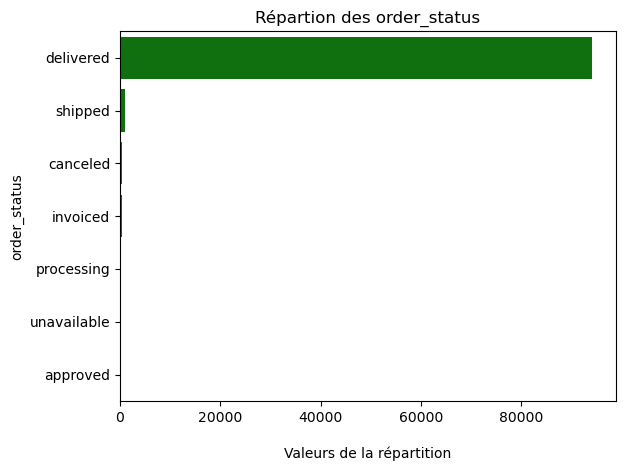

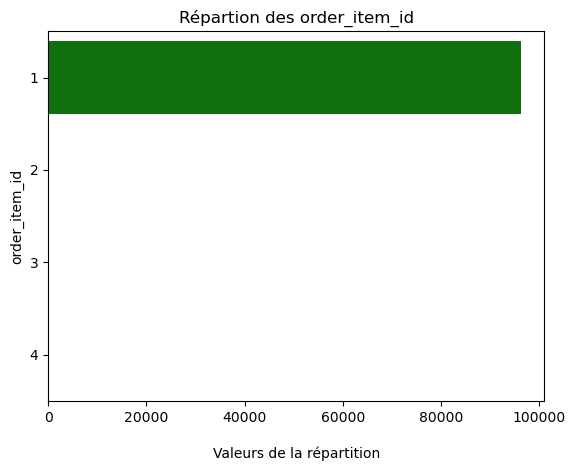

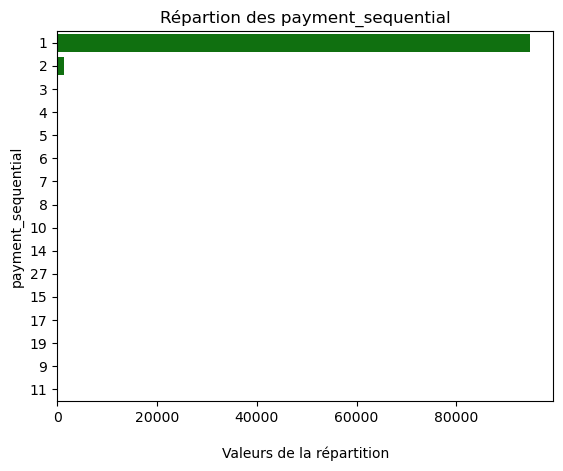

In [40]:
num = ["order_status", "order_item_id", "payment_sequential"]

for cols in num :
    sns.countplot(data=data, y=cols, order=data[cols].value_counts().index, color = 'green')
    plt.xlabel('\nValeurs de la répartition')
    plt.ylabel(cols)
    plt.title("Répartion des "+cols)
    plt.show()

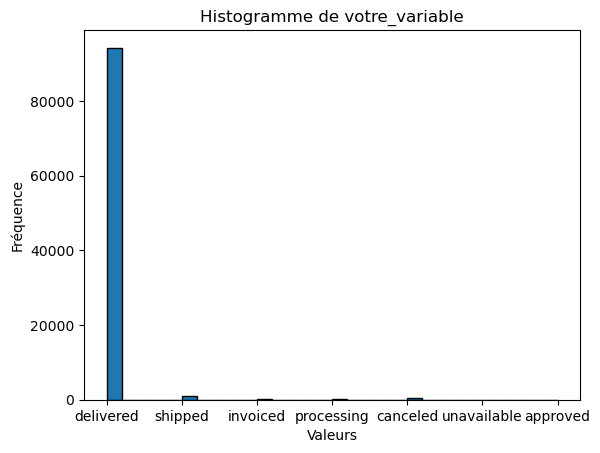

In [41]:
plt.hist(data['order_status'], bins=30, edgecolor='k')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.title('Histogramme de votre_variable')
plt.show()

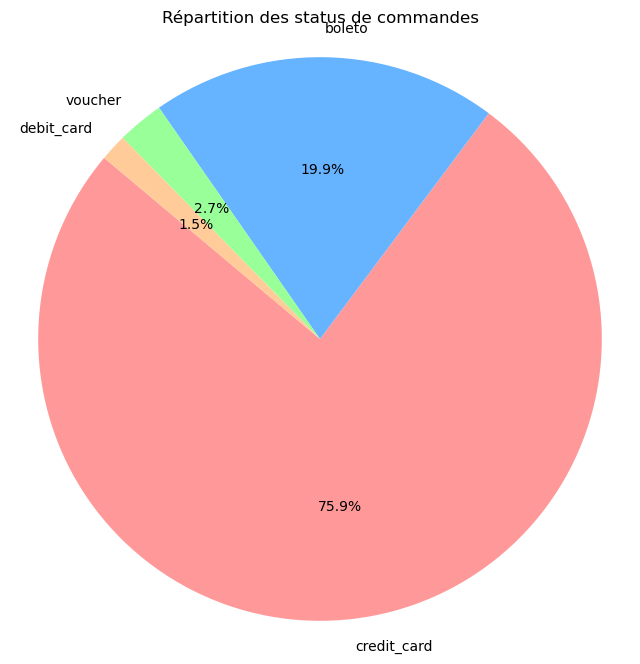

In [42]:
counts = data['payment_type'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Répartition des status de commandes')
plt.axis('equal') 
plt.show()

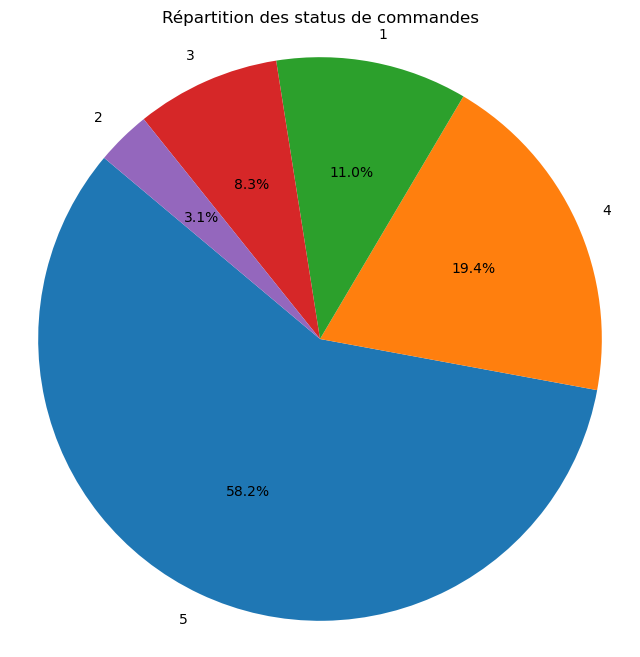

In [43]:
counts = data['review_score'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Répartition des status de commandes')
plt.axis('equal') 
plt.show()

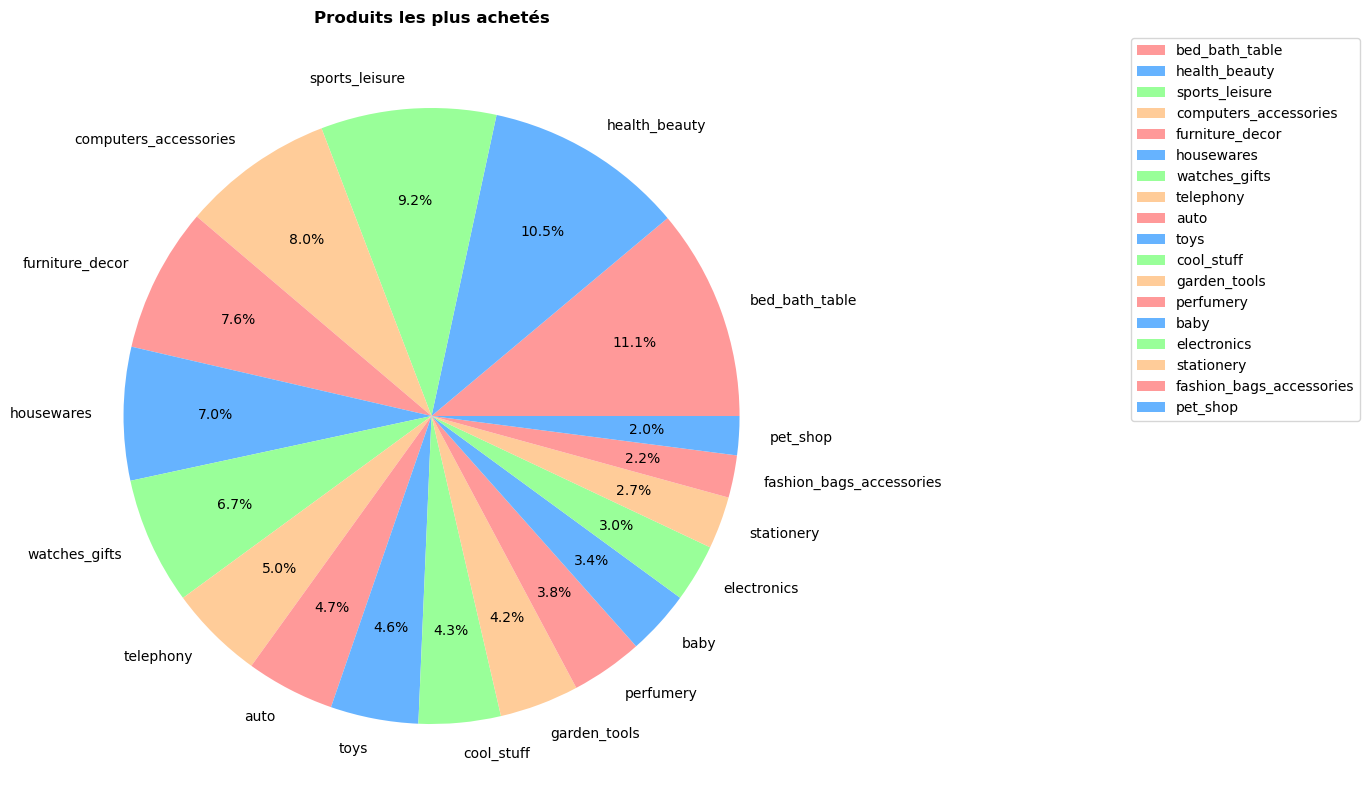

In [44]:
produit = data['product_category_name_english'].value_counts().head(18)

plt.rcParams["figure.figsize"] = (10,10)
plt.pie(produit, labels = produit.index, autopct='%1.1f%%', pctdistance = 0.7, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.legend(bbox_to_anchor=(1.4, 1.0), loc='upper left')
plt.title("Produits les plus achetés", fontsize=12,fontweight = 'bold')
plt.show()

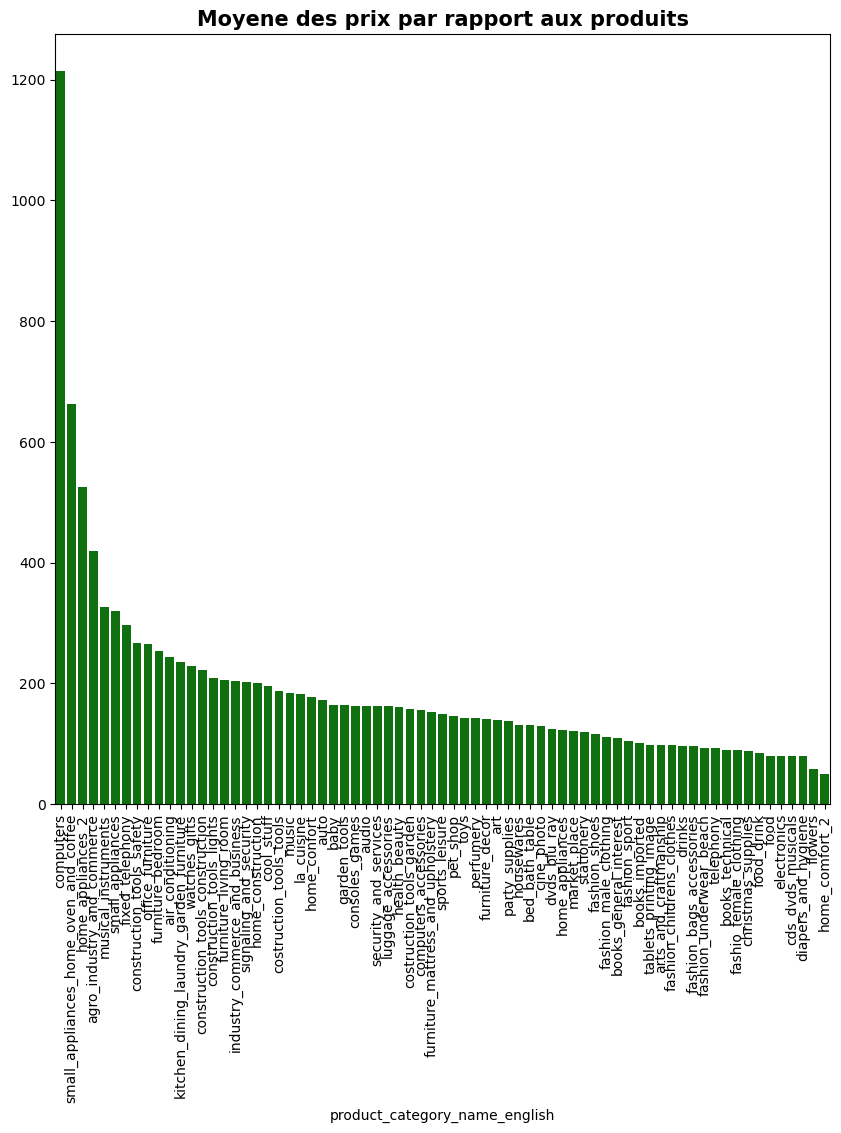

In [45]:
prod_arg = data[["product_category_name_english", 'payment_value']]
prod_arg = prod_arg.groupby('product_category_name_english').mean()
prod_arg = prod_arg.sort_values(by = "payment_value", ascending = False)
prod_arg = prod_arg.transpose()

fig,ax = plt.subplots()
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 15})
sns.barplot(data = prod_arg, color = 'green')
ax.tick_params(axis='x', rotation=90)
plt.title("Moyene des prix par rapport aux produits", fontsize=15,fontweight = 'bold')
plt.show()

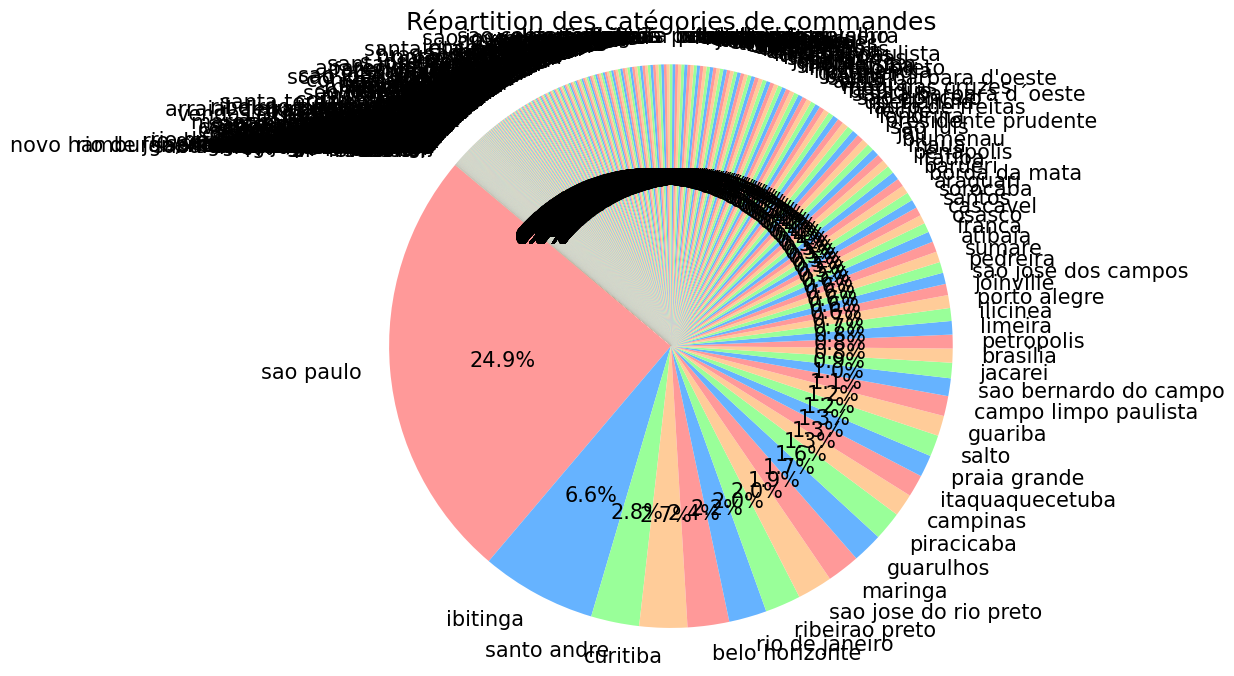

In [46]:
counts = data['seller_city'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Répartition des catégories de commandes')
plt.axis('equal') 
plt.show()

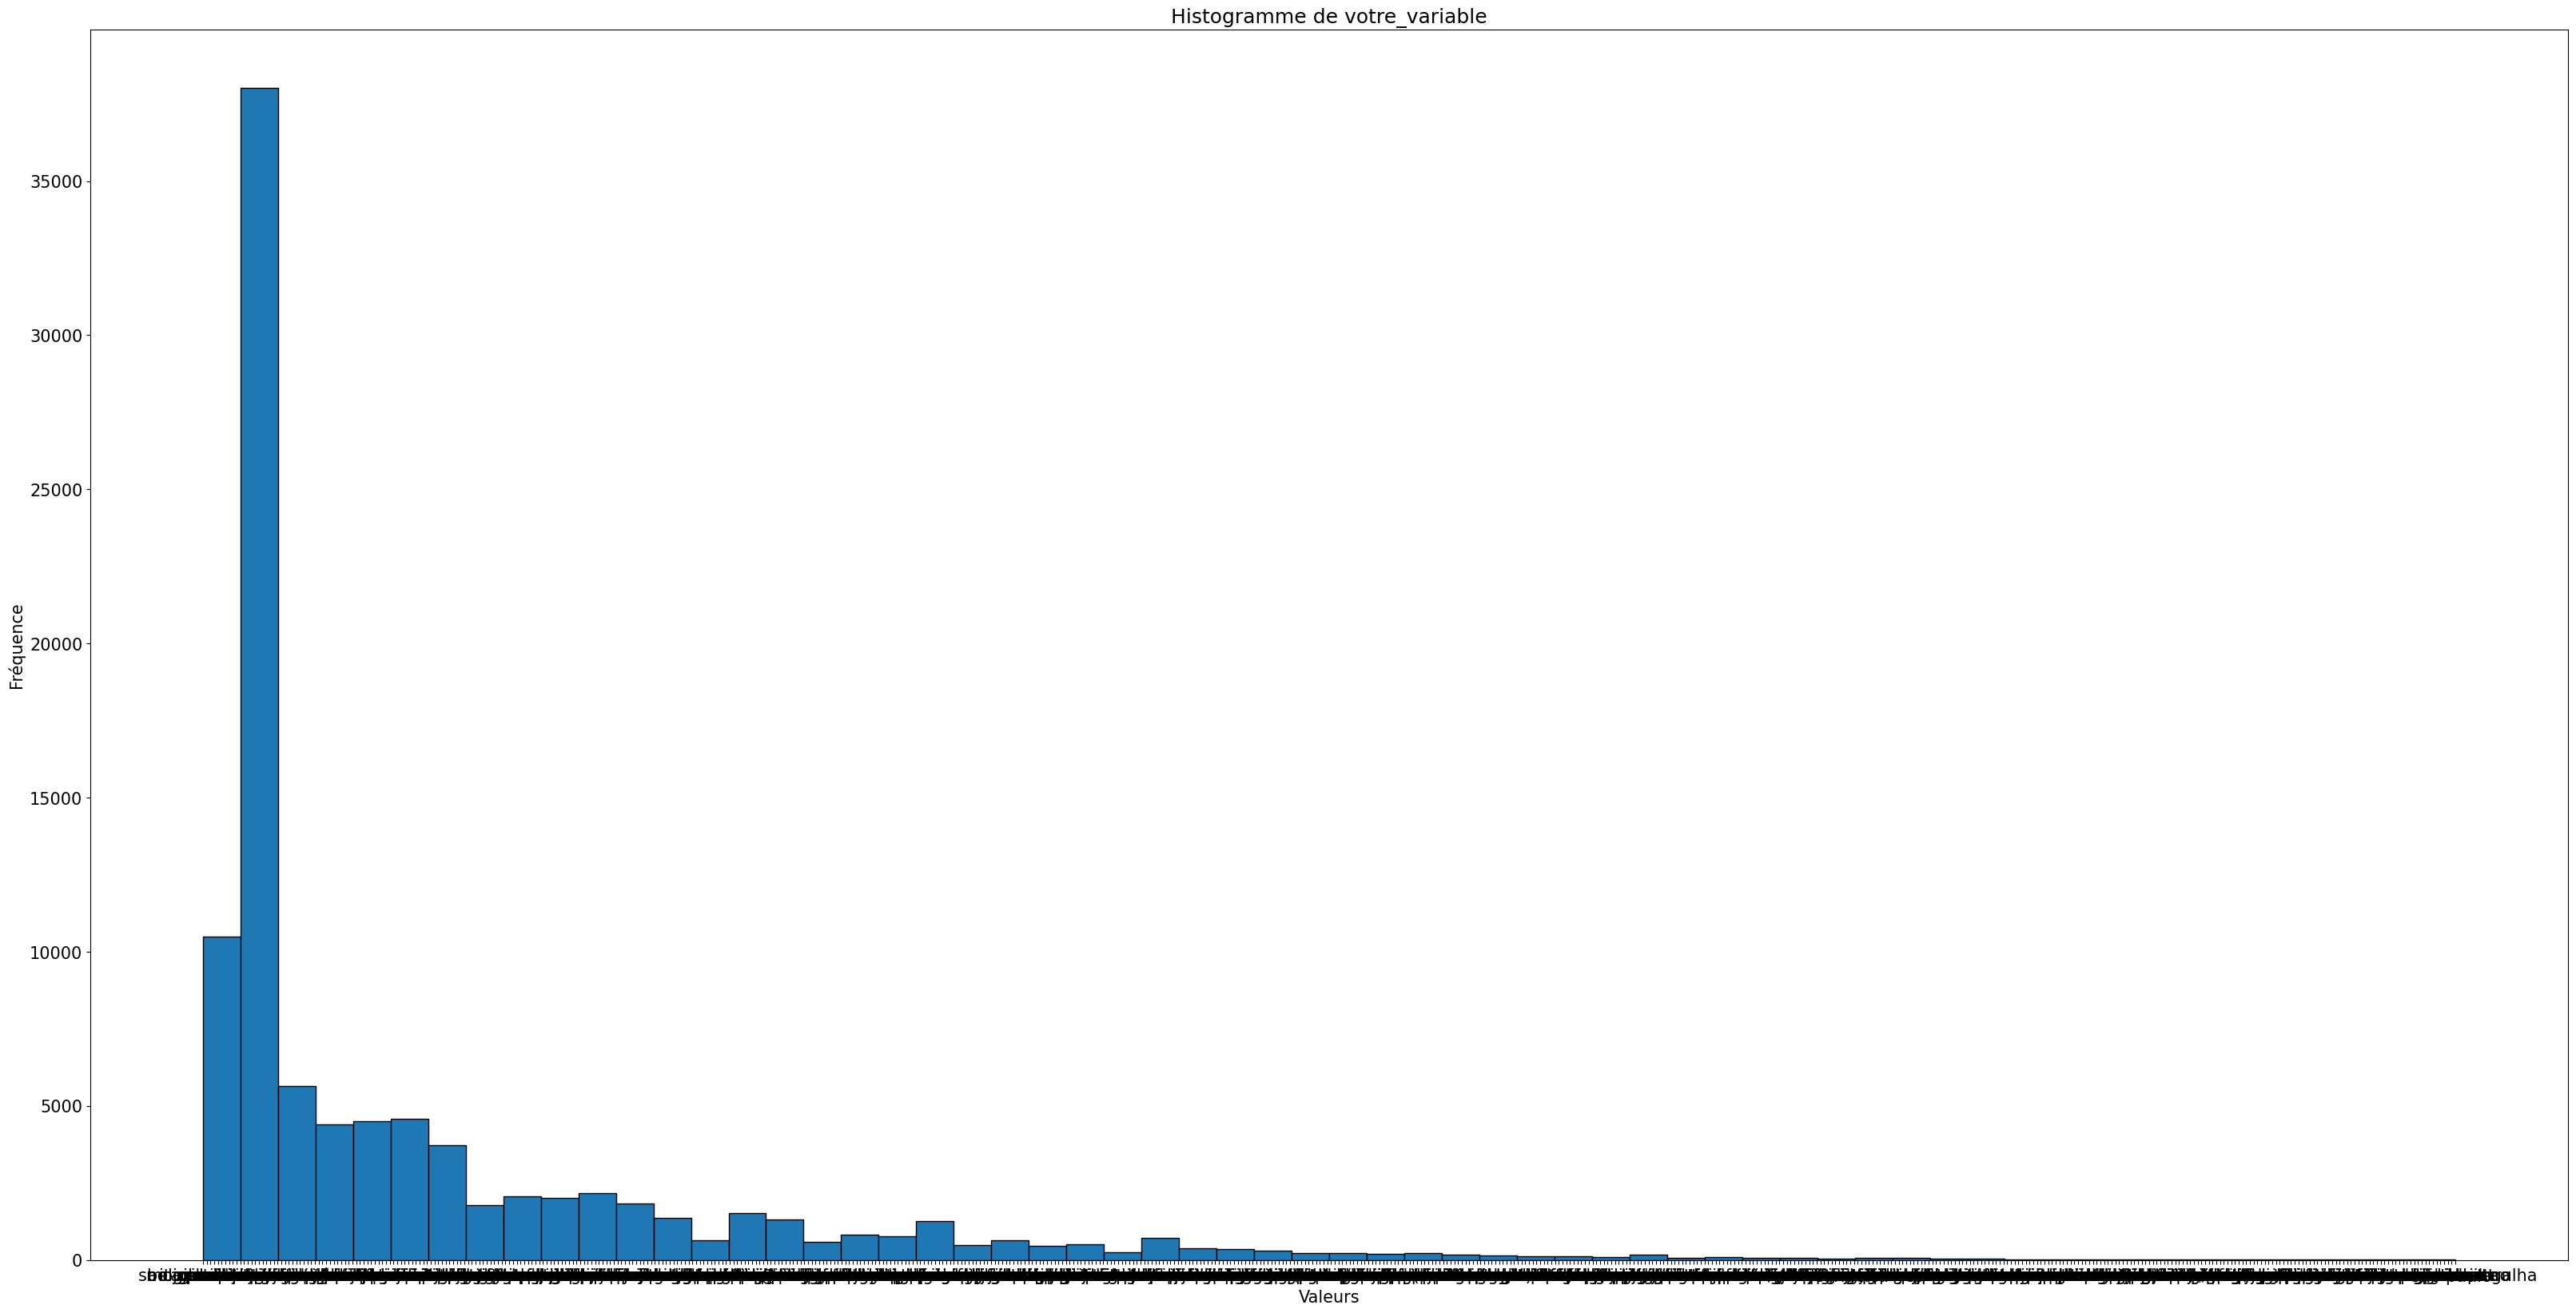

In [47]:
plt.figure(figsize=(40, 20))
plt.hist(data['seller_city'], bins=60, edgecolor='k')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.title('Histogramme de votre_variable')
plt.show()

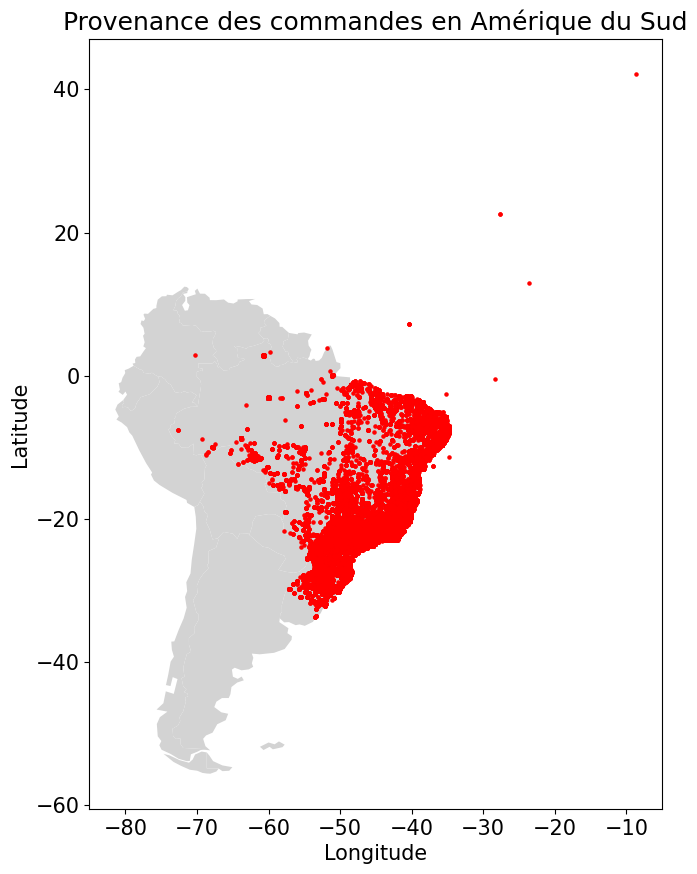

In [48]:
# Créer un GeoDataFrame à partir du DataFrame pandas
gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data.geolocation_lng, data.geolocation_lat))

# Charger une carte de l'Amérique du Sud
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
south_america = world[(world.continent == 'South America')]

# Plotter la carte
fig, ax = plt.subplots(figsize=(10, 10))
south_america.plot(ax=ax, color='lightgrey')
gdf.plot(ax=ax, color='red', markersize=5)

# Ajouter des titres et labels si nécessaire
plt.title('Provenance des commandes en Amérique du Sud')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Afficher la carte
plt.show()

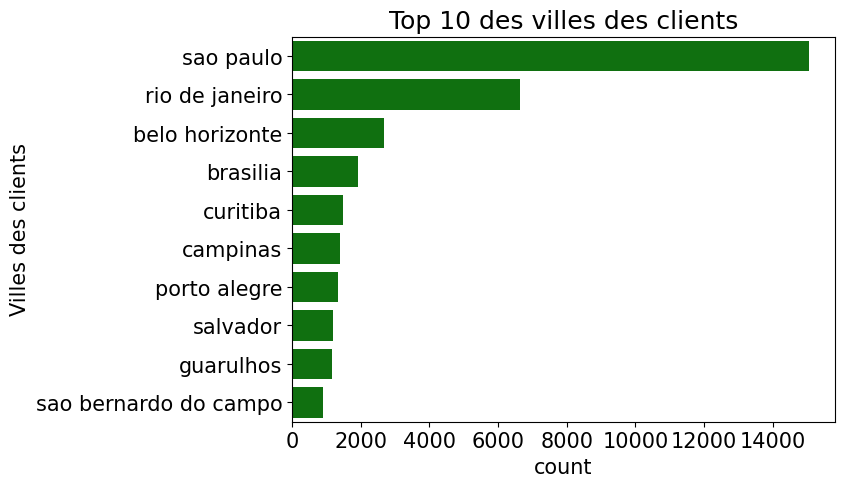

In [49]:
plt.figure(figsize=(7,5))
sns.countplot(y="customer_city", data=data, order=data["customer_city"].value_counts().index[:10], color = 'green')
plt.title("Top 10 des villes des clients")
plt.ylabel("Villes des clients")
plt.show()

Text(0.5, 1.0, 'Répartition du prix des commandes')

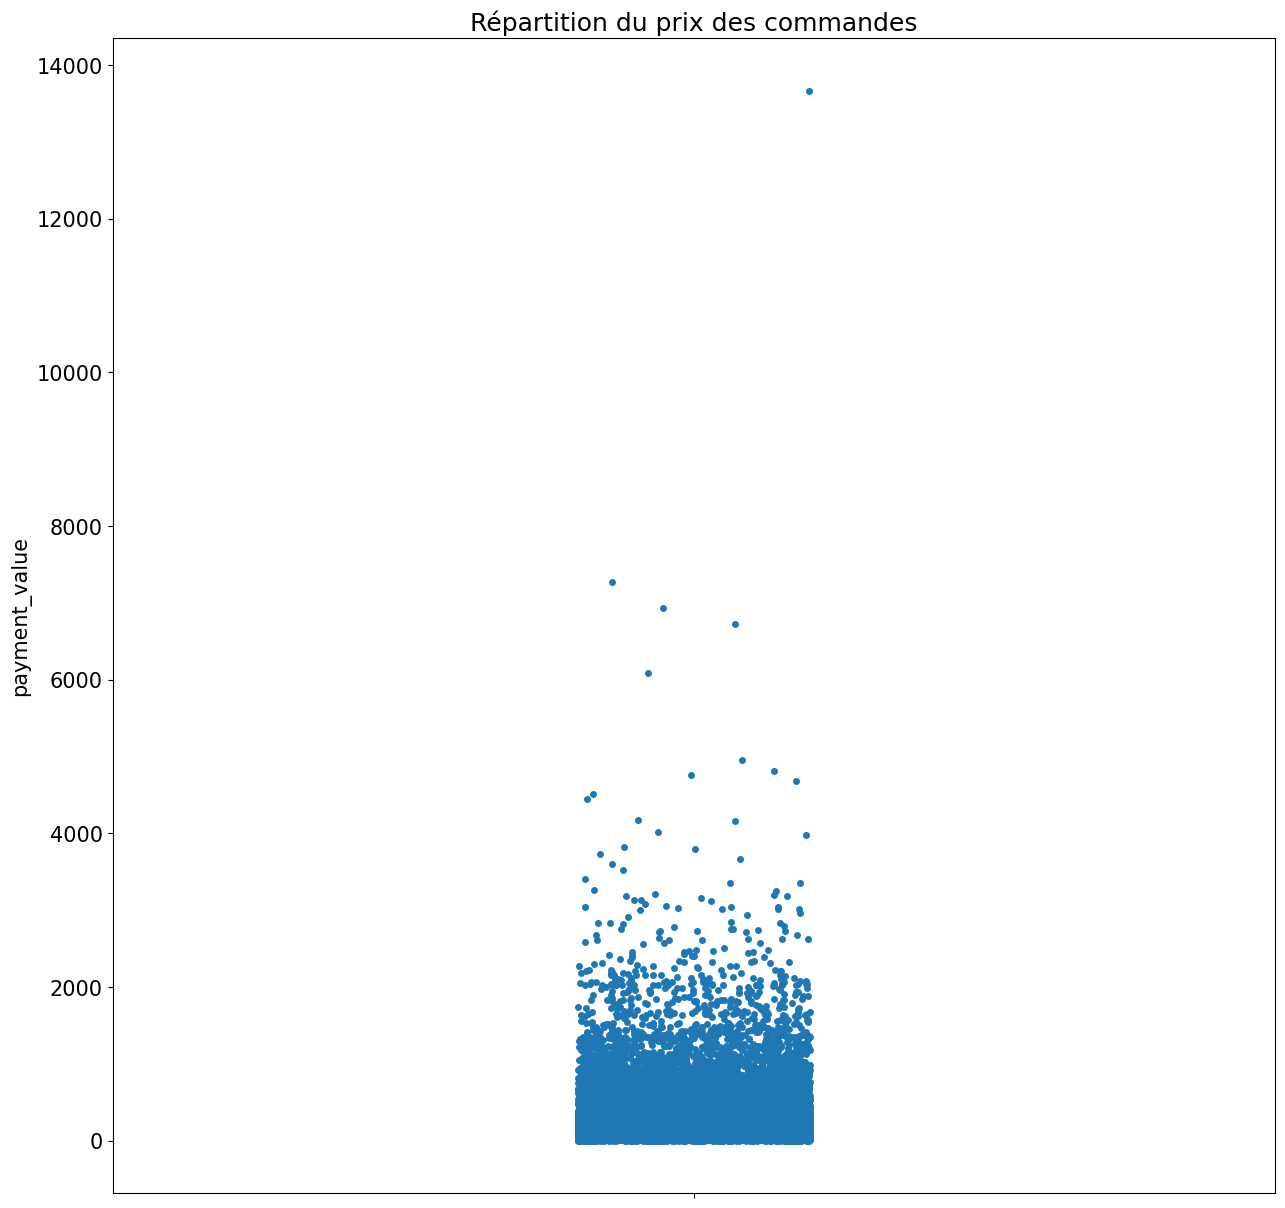

In [50]:
sns.stripplot(data = data["payment_value"])
plt.title("Répartition du prix des commandes")

Text(0.5, 1.0, 'Distribution du prix des commandes')

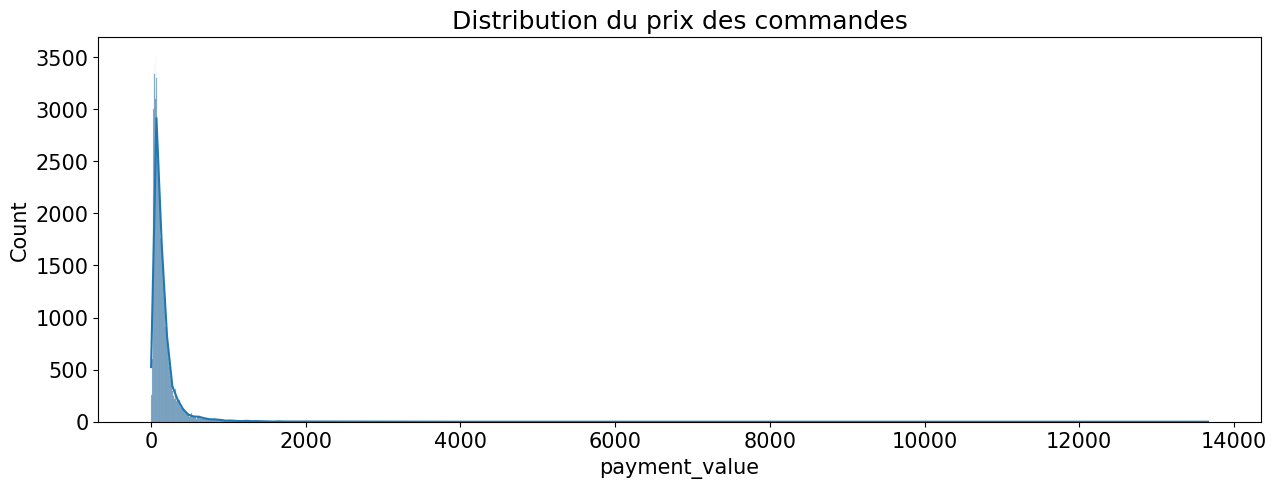

In [51]:
fig, axes = plt.subplots(figsize=(15, 5), sharex=True)
sns.histplot(x="payment_value", data=data, kde=True)
plt.title("Distribution du prix des commandes")

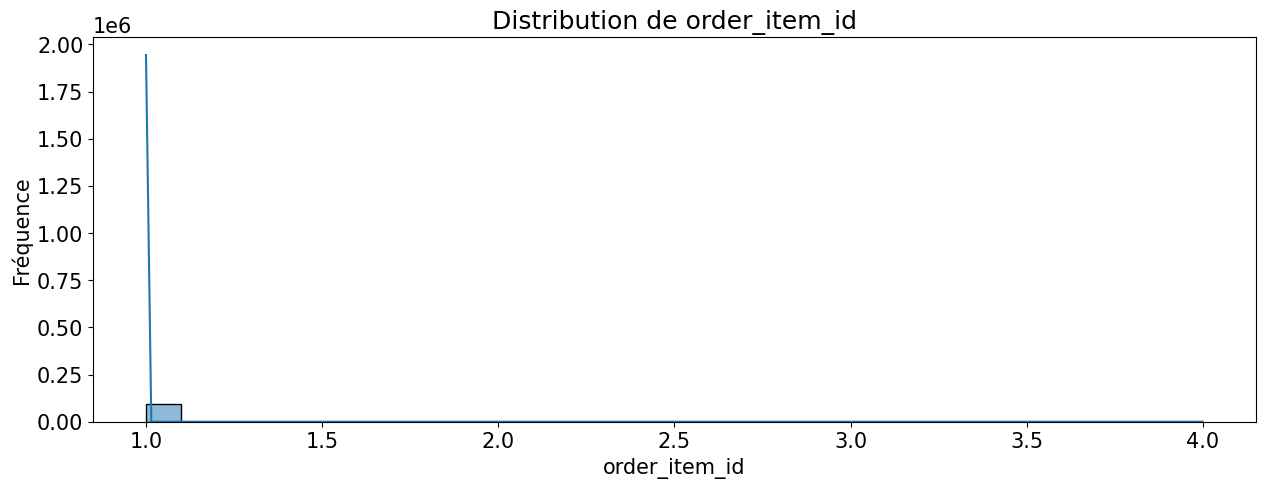

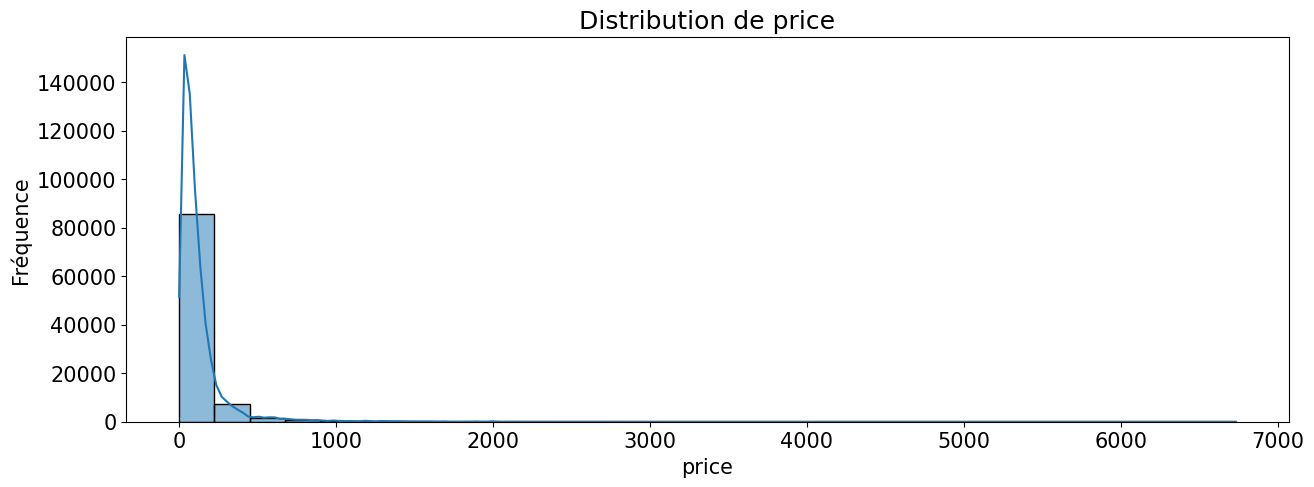

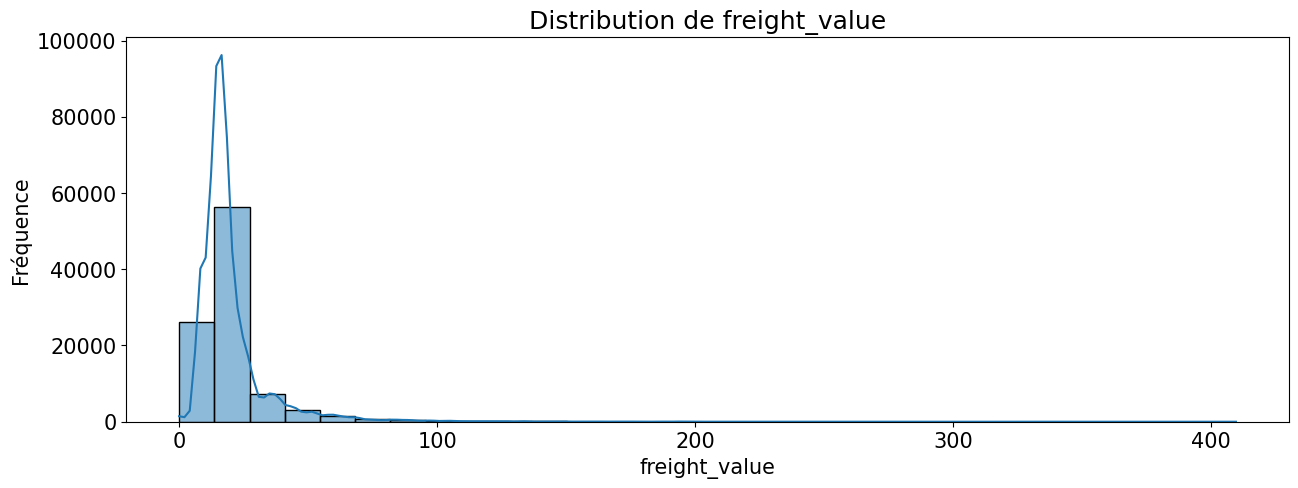

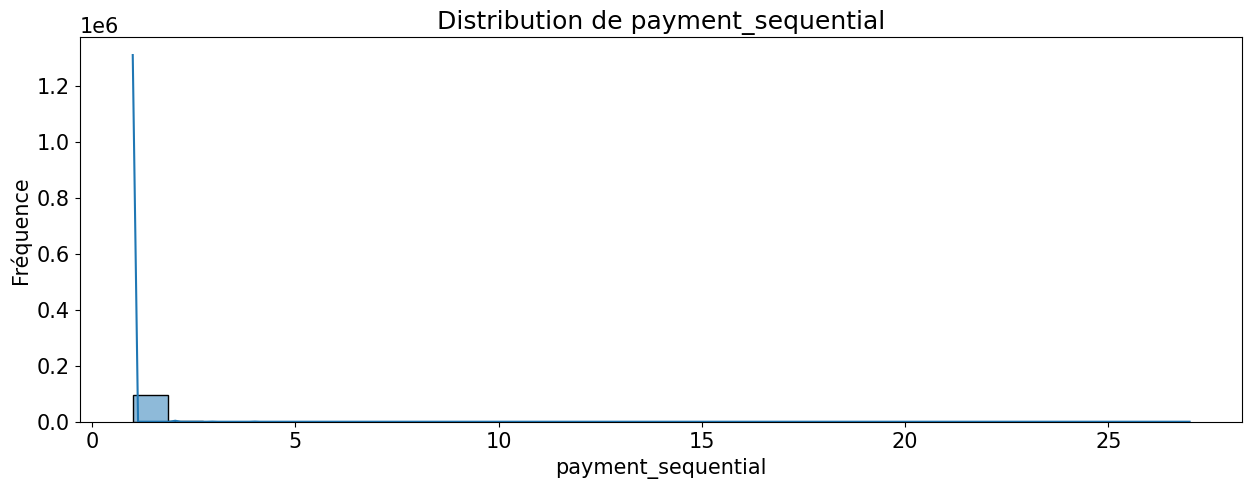

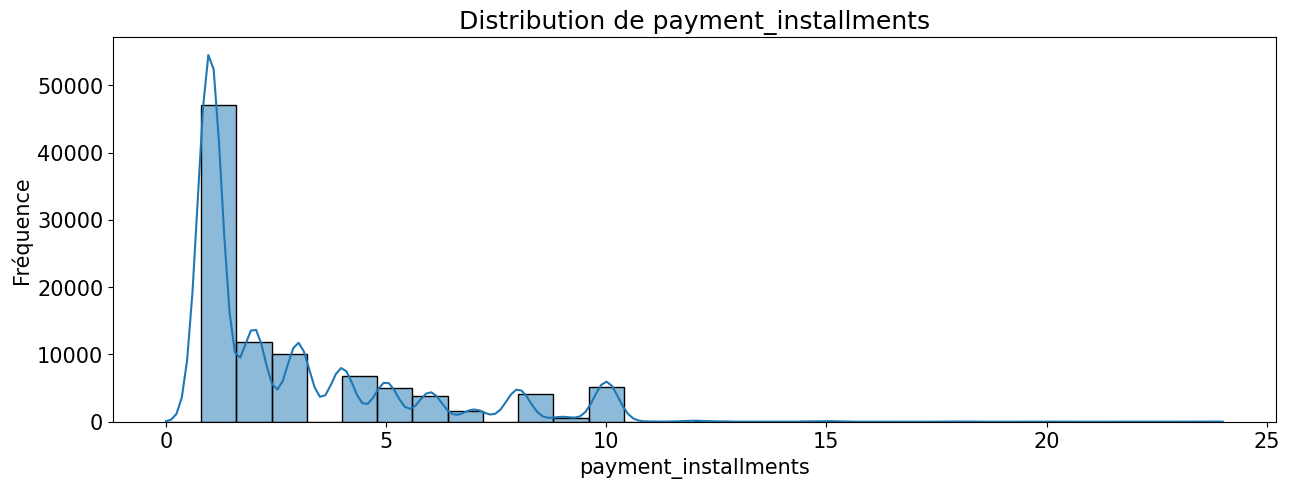

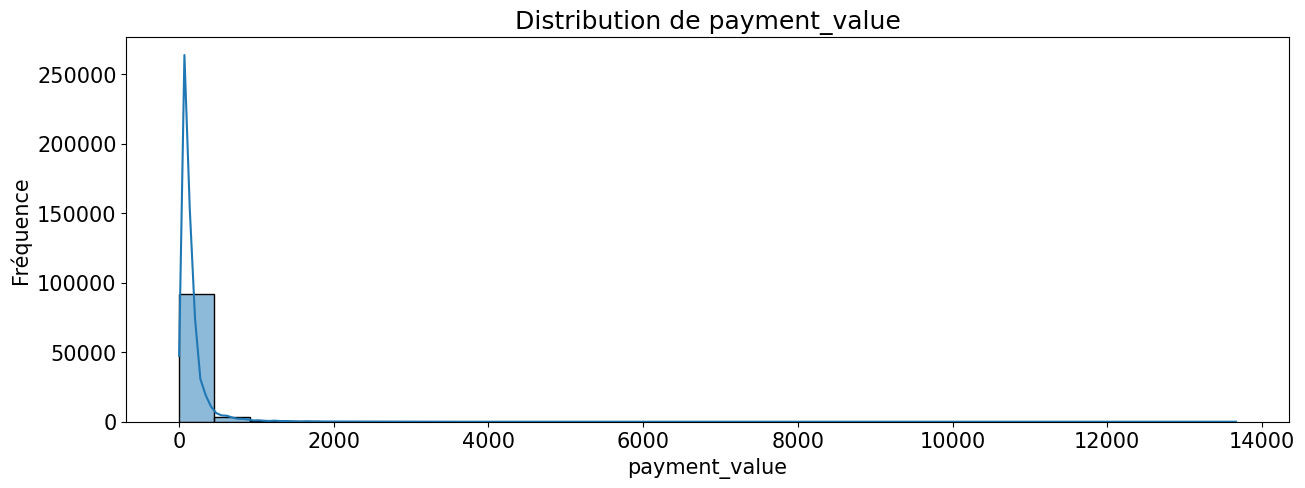

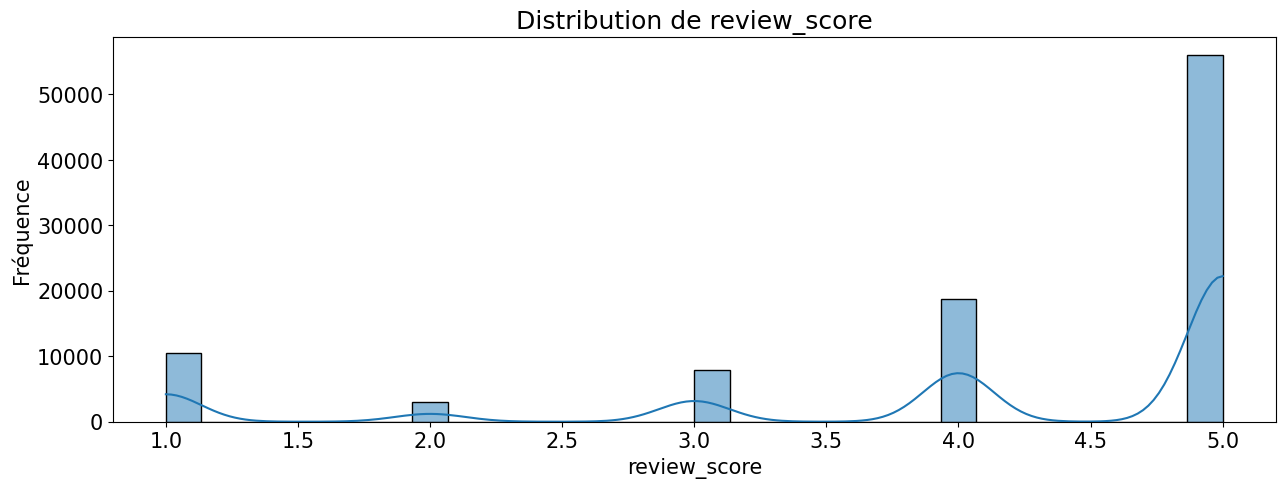

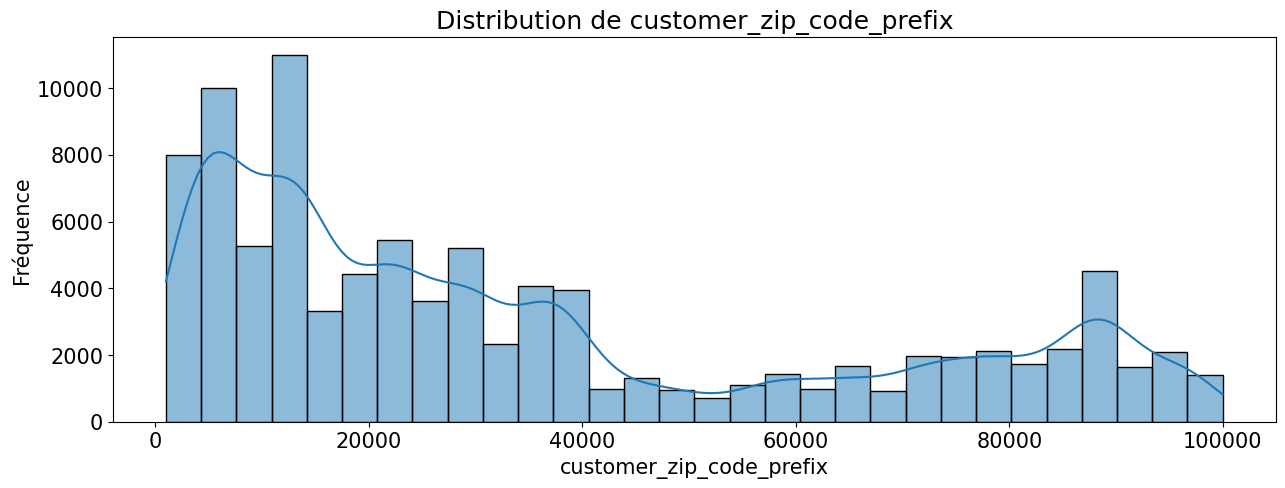

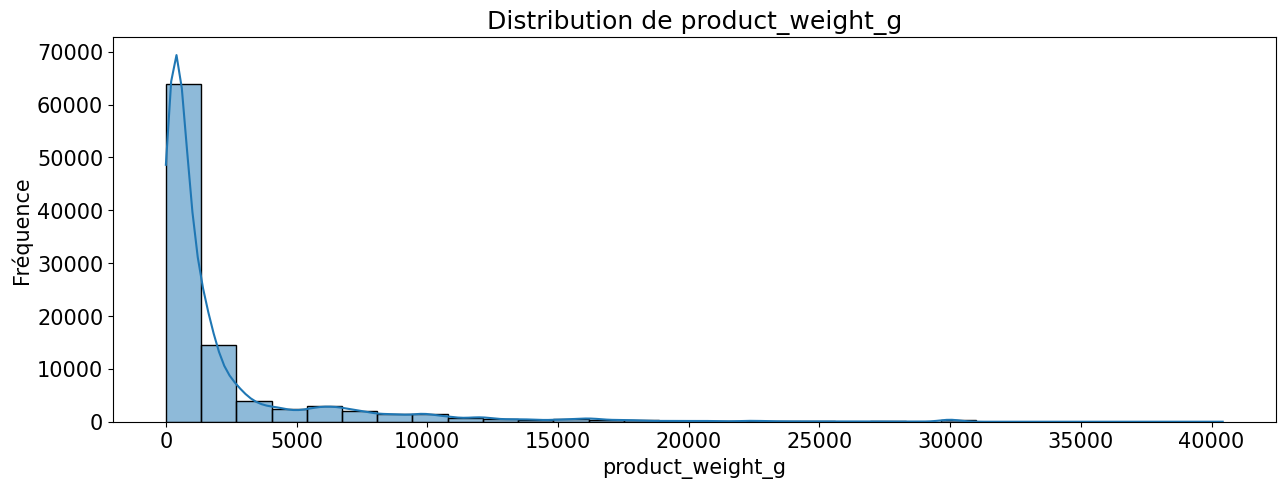

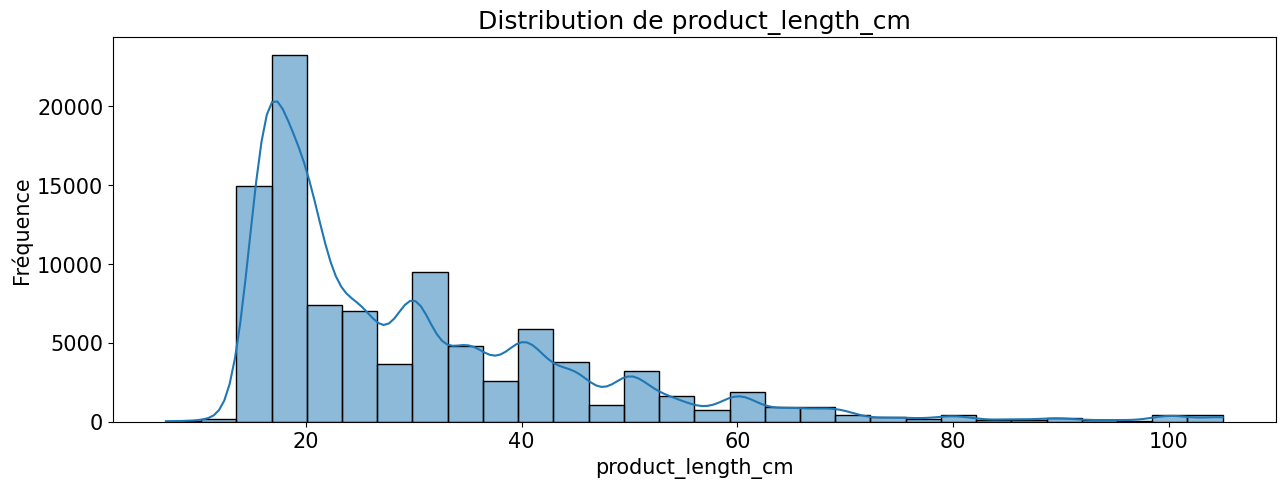

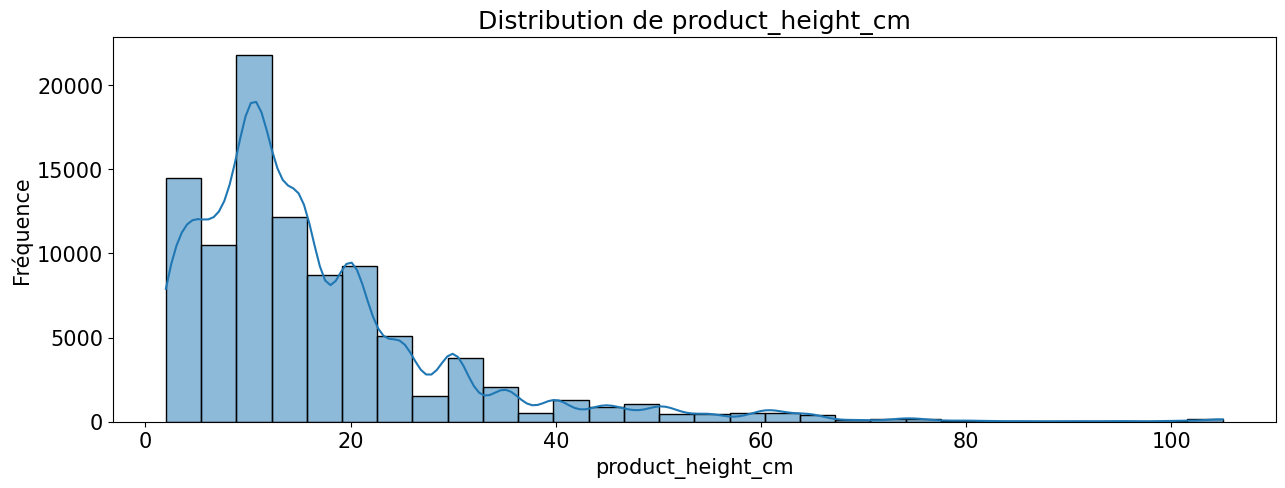

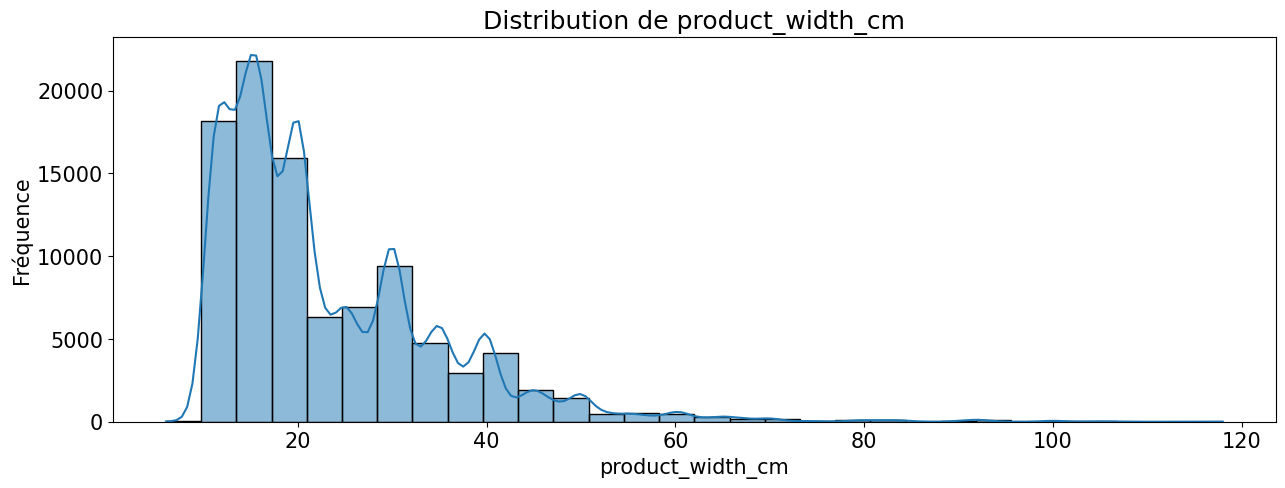

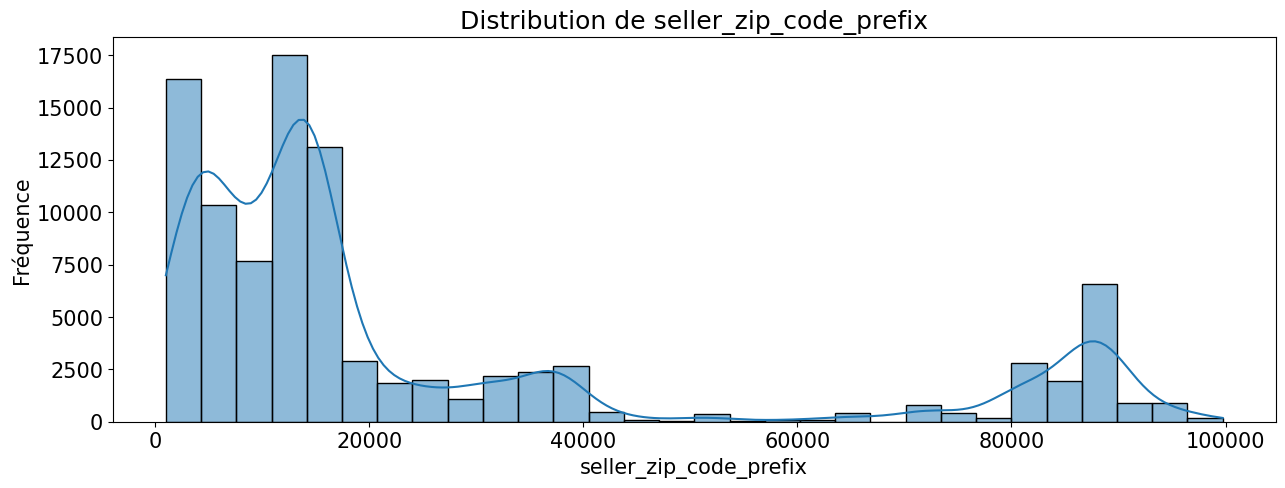

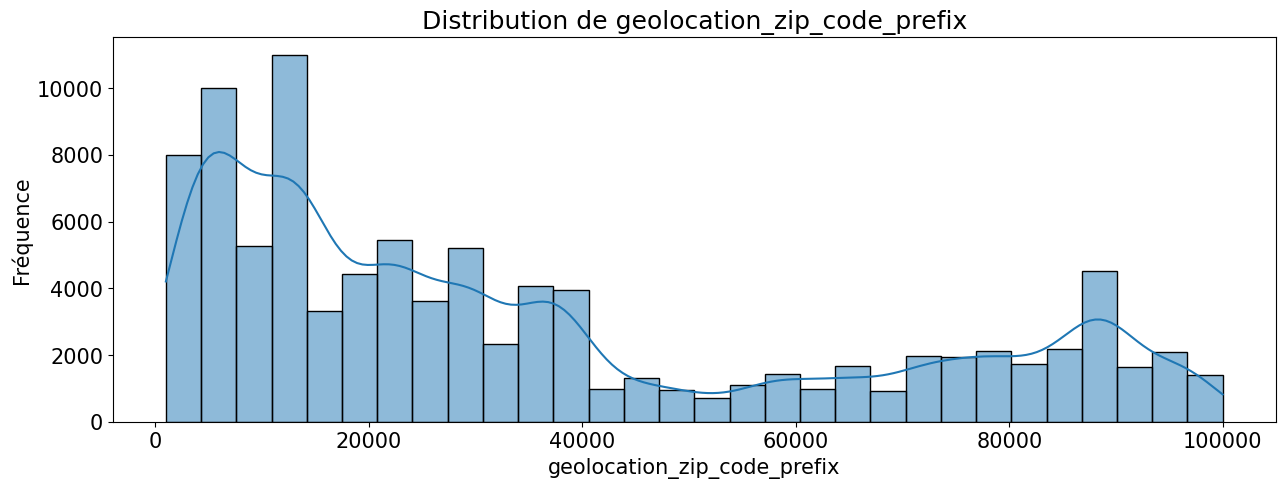

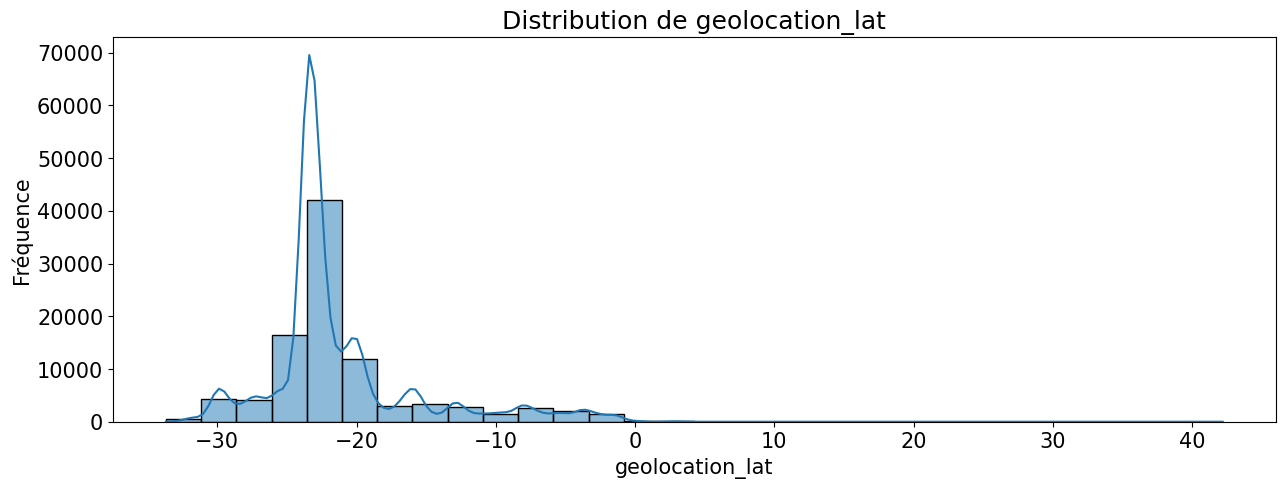

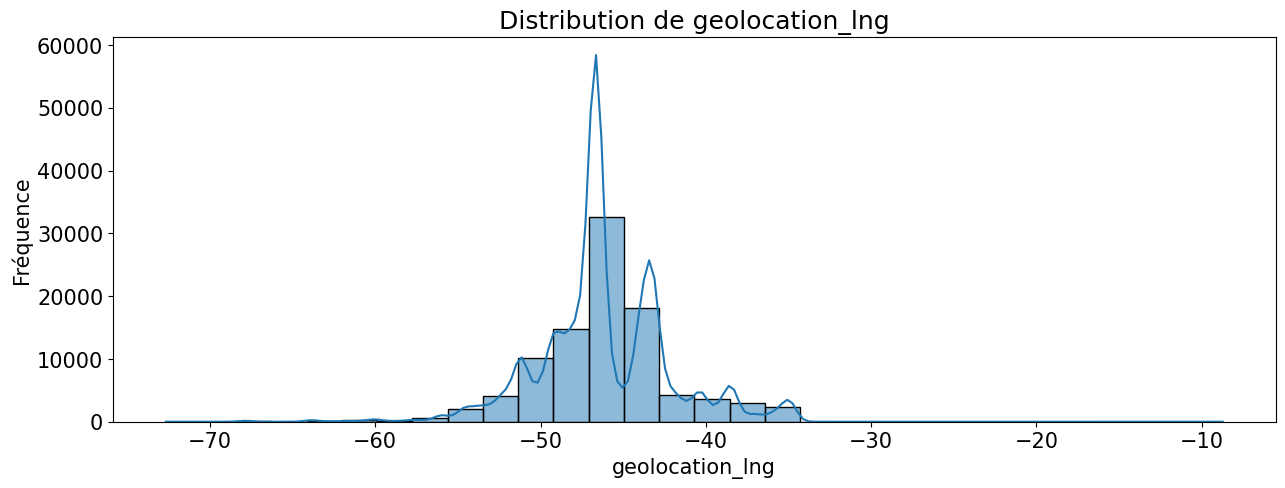

In [56]:
for column in data.select_dtypes(['int64', 'float64']).columns:
    plt.figure(figsize=(15, 5))  # Créer une nouvelle figure pour chaque colonne
    sns.histplot(data[column], bins=30, kde=True)  # Utiliser histplot pour les histogrammes
    plt.title('Distribution de ' + str(column))  # Ajouter le titre
    plt.xlabel(column)  # Étiqueter l'axe des x
    plt.ylabel('Fréquence')  # Étiqueter l'axe des y
    plt.show()  # Afficher le graphique

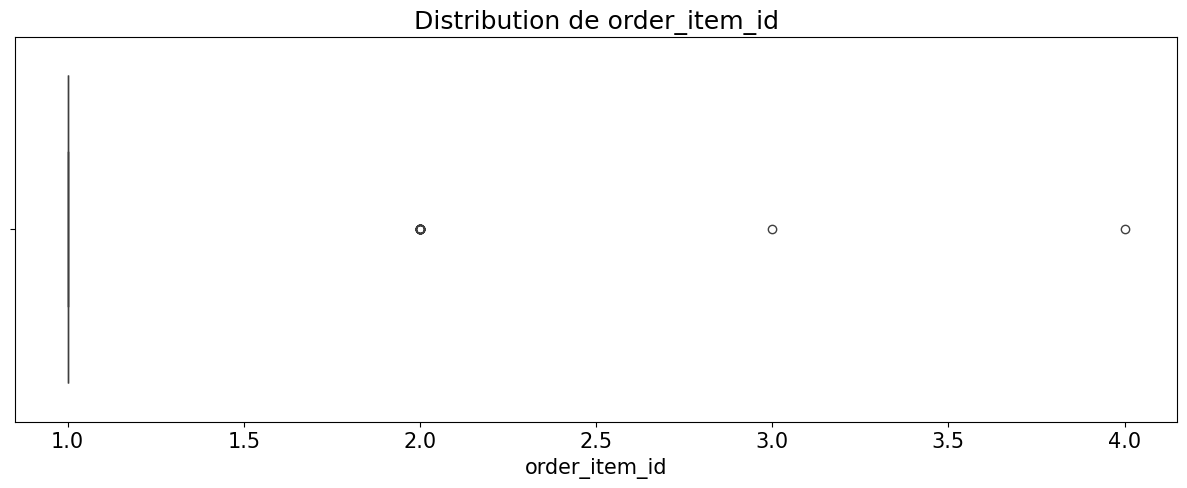

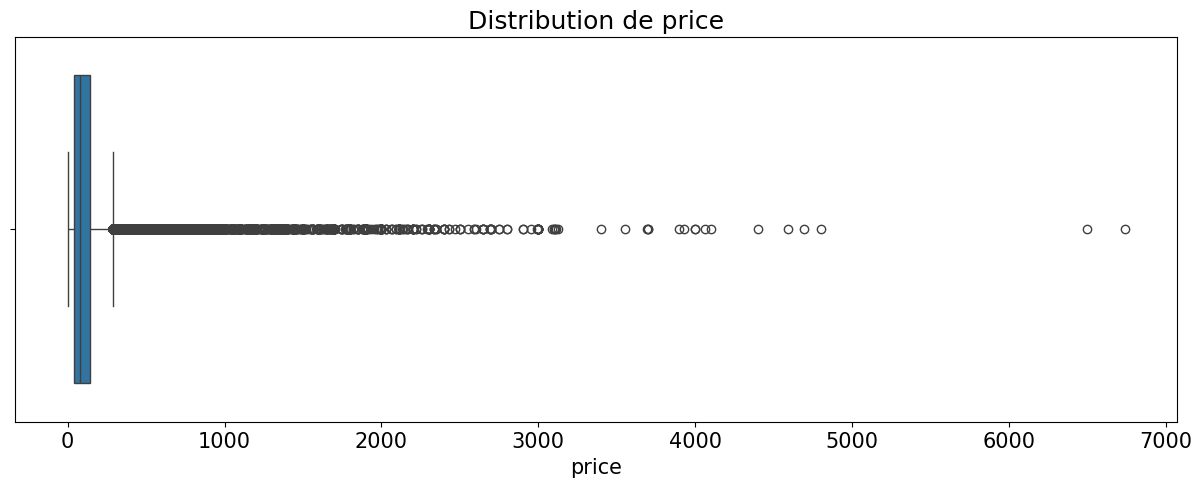

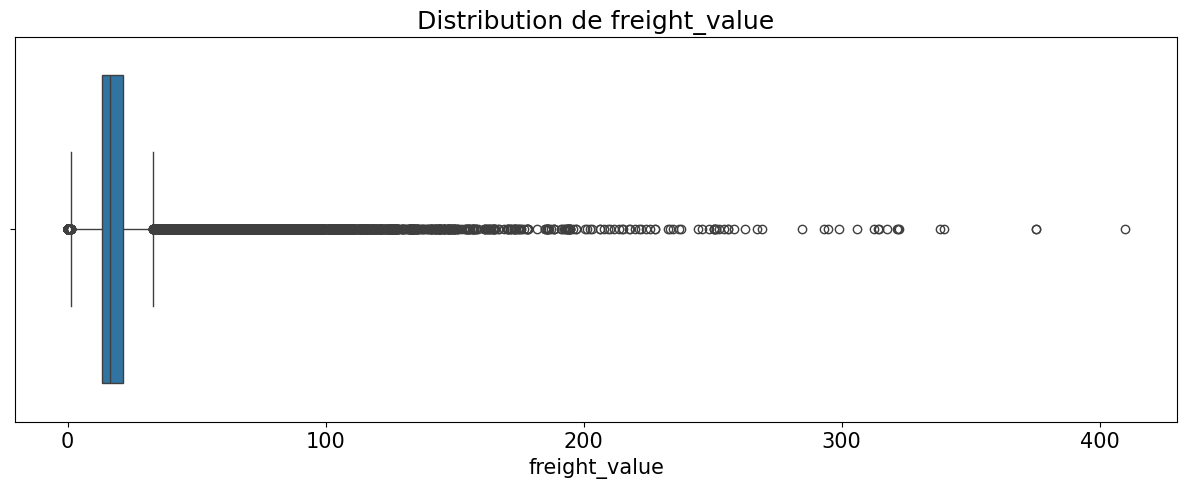

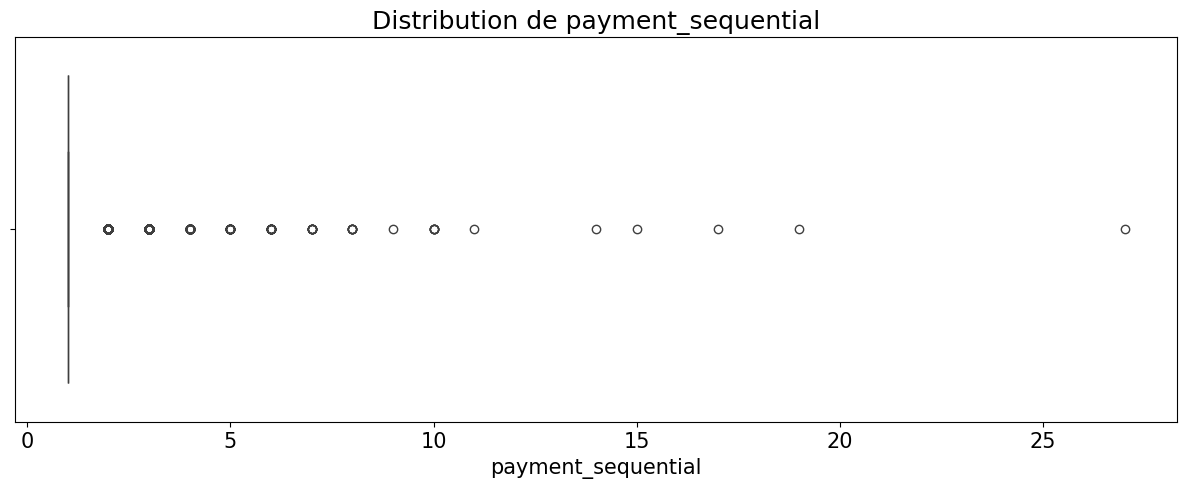

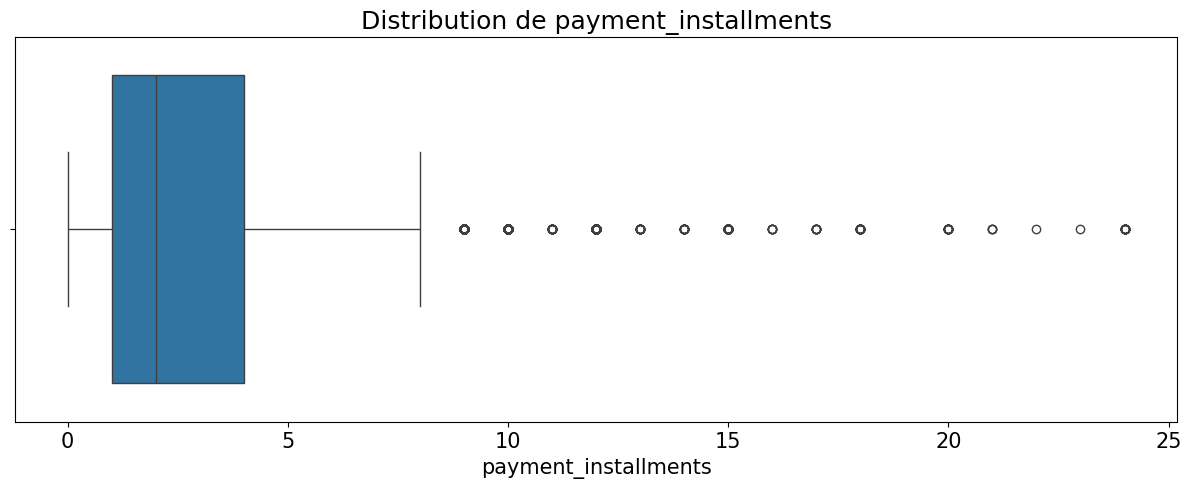

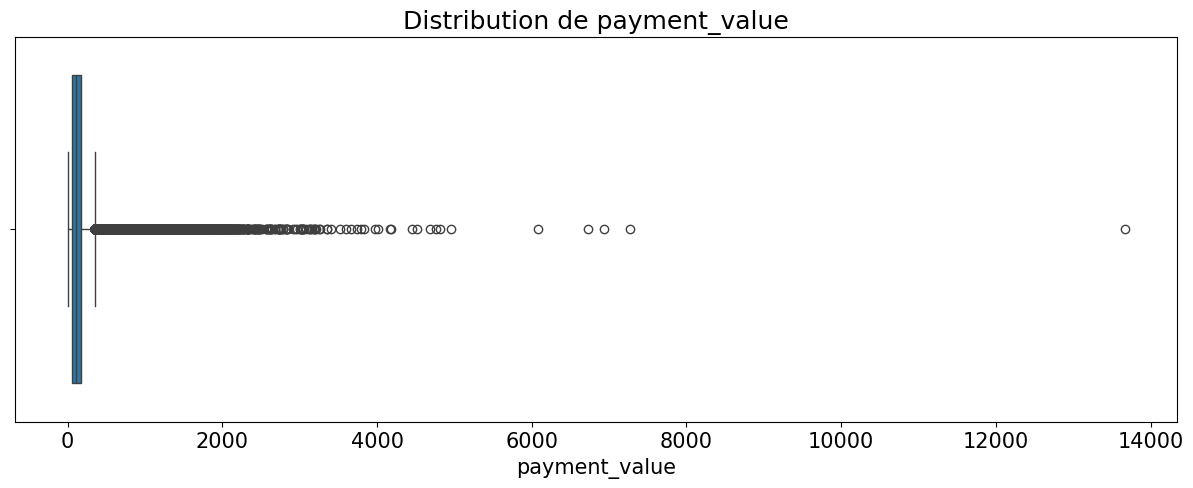

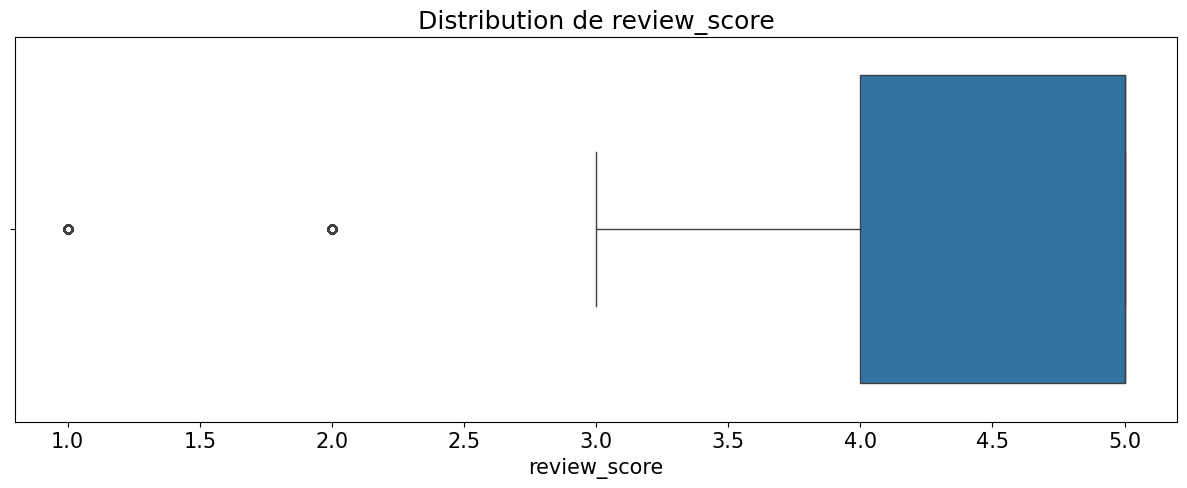

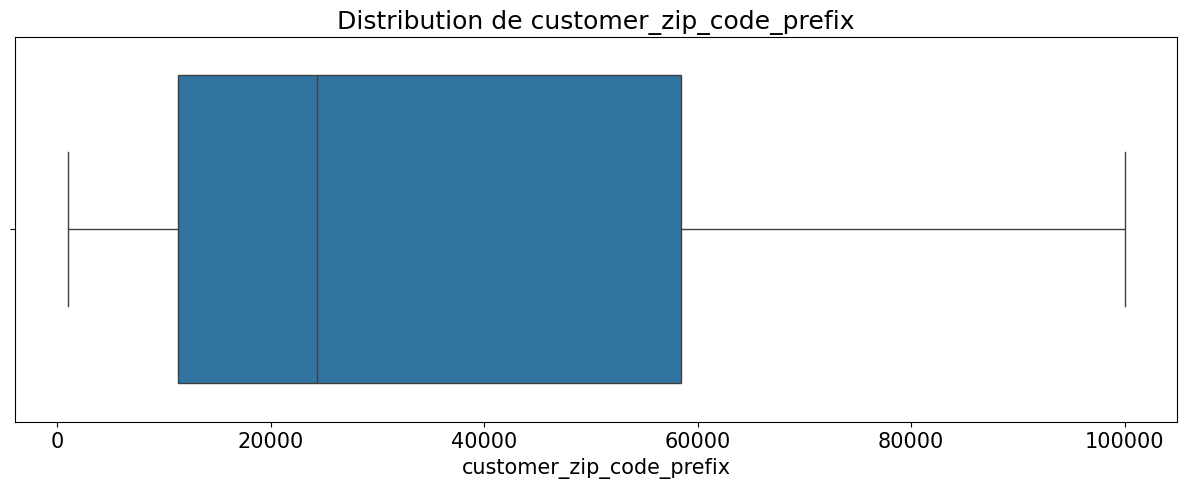

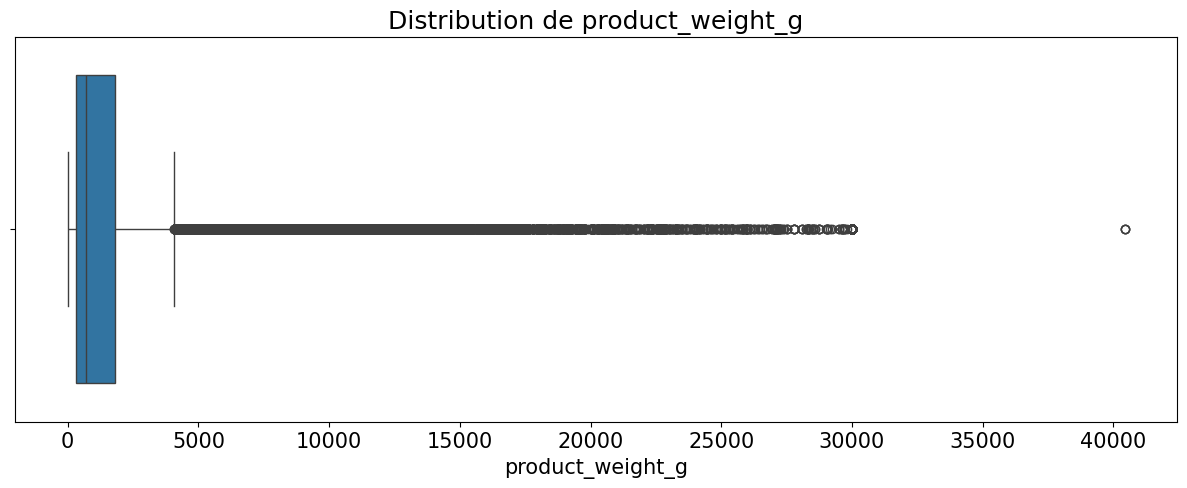

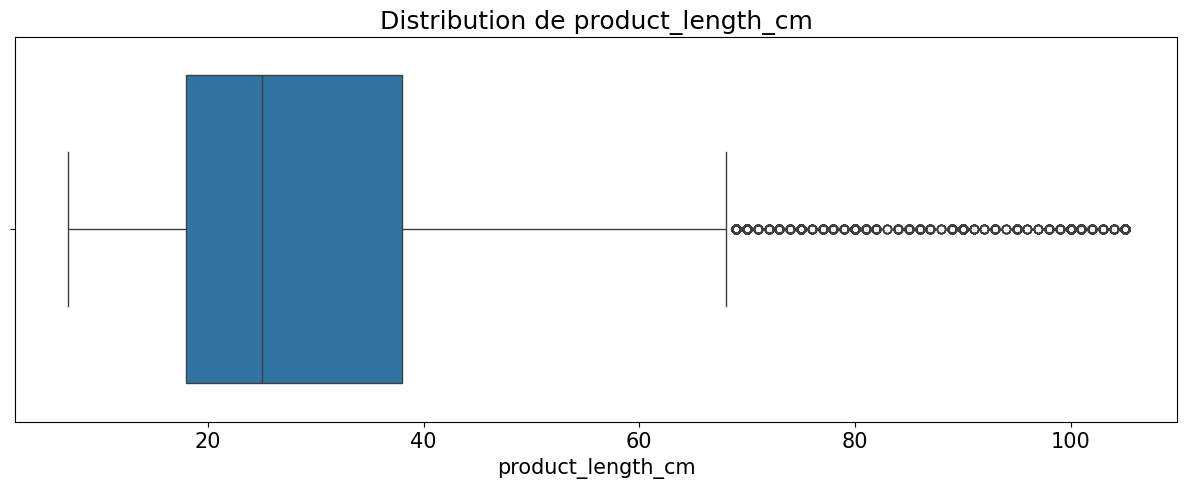

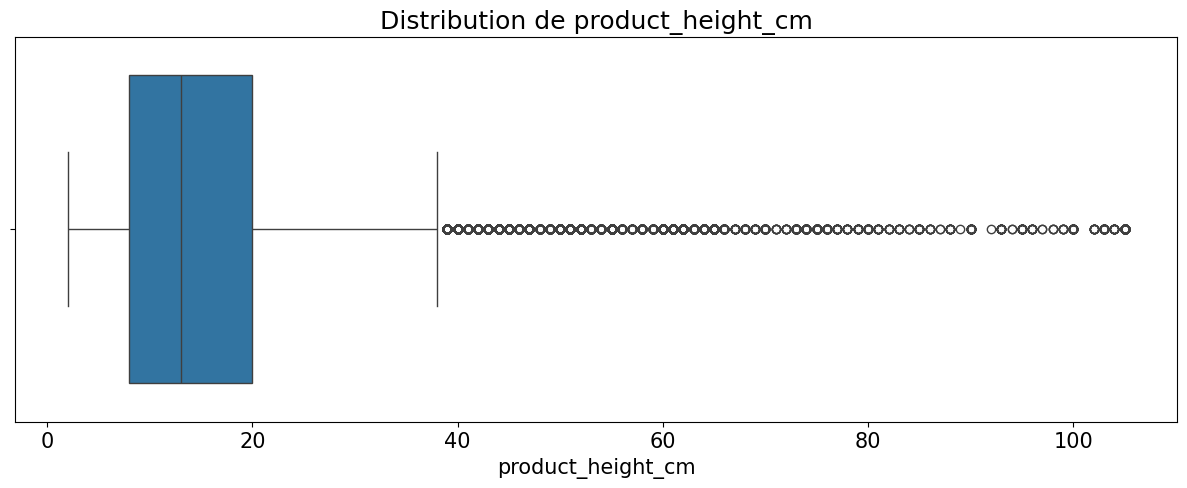

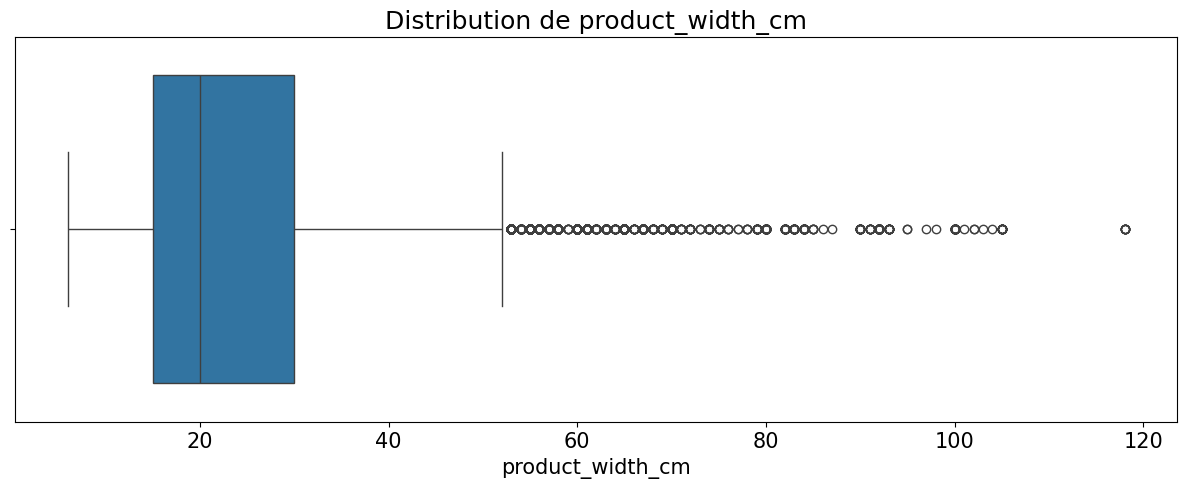

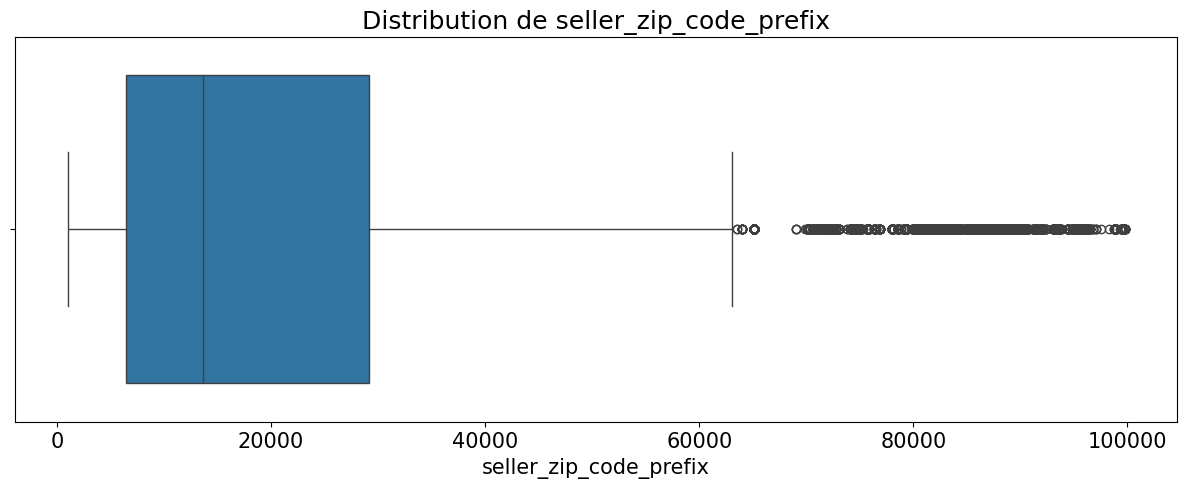

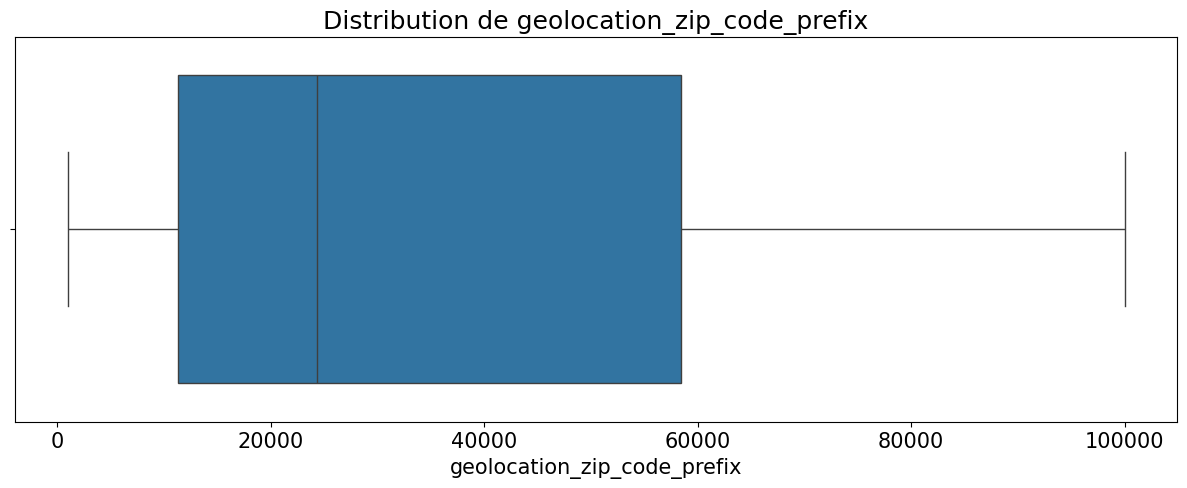

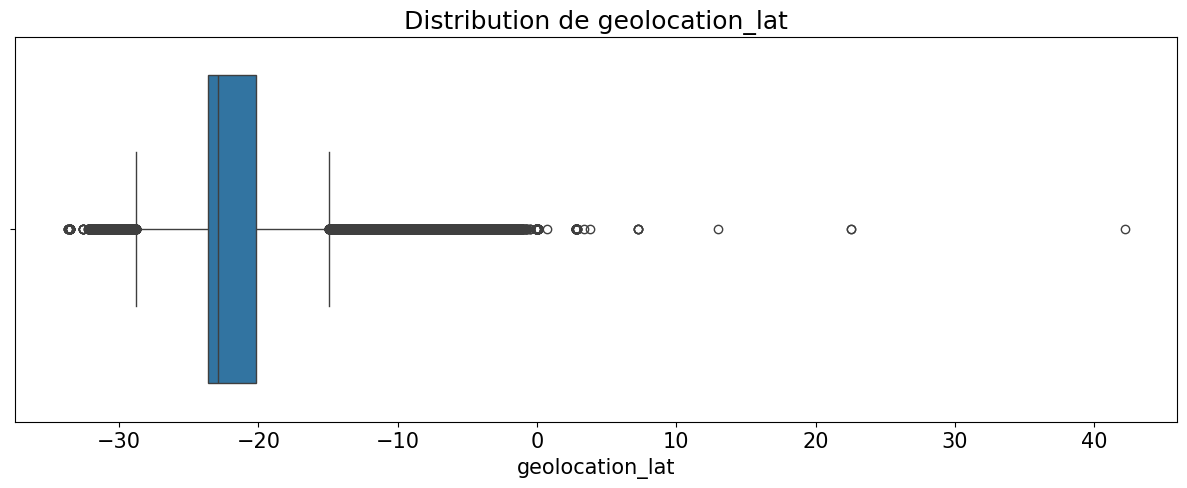

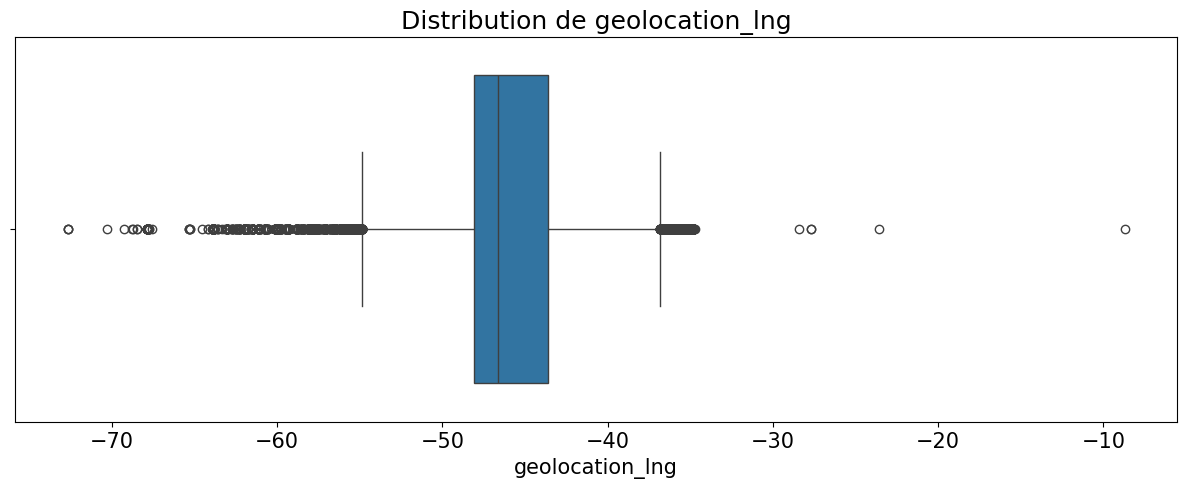

In [58]:
for column in data.select_dtypes(['int64', 'float64']).columns:
    plt.figure(figsize=(15, 5))  # Crée une nouvelle figure pour chaque colonne
    sns.boxplot(x=data[column])  # Utilise boxplot pour tracer le diagramme en boîte
    plt.title('Distribution de ' + str(column))  # Ajoute le titre
    plt.xlabel(column)  # Étiquette de l'axe des x
    plt.show()  # Affiche le graphique